# Imports

In [1]:
!pip3 install openai
!pip3 install ipympl
!pip3 install tiktoken
!pip3 install sentence-transformers
!sudo apt-get install gcc python3-dev python3-setuptools
!sudo pip3 uninstall crcmod
!sudo pip3 install --no-cache-dir -U crcmod

from google.colab import output # the output module provides functionality for controlling the output display of code cells in a Jupyter notebook.
output.enable_custom_widget_manager() #  enable_custom_widget_manager is used to enable custom widget management in a Colab notebook.
                                        #Widgets are interactive elements that can be added to Jupyter notebooks to create graphical user interfaces, interactive visualizations, and other dynamic content.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import openai
import torch
import random
import numpy as np
import pandas as pd
import warnings
import plotly.express as px

import time
import math
import concurrent.futures
from tqdm import tqdm_notebook
from openai.embeddings_utils import get_embedding
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity


from tqdm import tqdm
from typing import List, Tuple
from tqdm import tqdm_notebook
from bs4 import BeautifulSoup

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

# Useful to read dataframes inline
def display_html(df):
    display(HTML(df.to_html()))

warnings.filterwarnings("ignore")

In [4]:
use_cuda = torch.cuda.is_available()
use_cuda

False

In [ ]:
#Pk: Bert is used to get hard negative samples

In [5]:
LANG_BACKEND_PATH = "/content/drive/MyDrive/language_backend"
DATA_PATH = f"{LANG_BACKEND_PATH}/data"
MODELS_PATH = f"{LANG_BACKEND_PATH}/models"

FINETUNING_EMBEDDINGS_PATH = f"."

BEST_MATRIX_FILE_NAME = 'best_matrix.npy'

# COLUMN NAMES
QUERY_COL = "question_text"
PASSAGE_COL = "candidate_answers"
QUERY_EMB_COL = f'{QUERY_COL}_EMB'
PASSAGE_EMB_COL = f'{PASSAGE_COL}_EMB'


# Path to preprocessed datasets
PREPROCESSED_DATASETS_PATH = "/content/drive/MyDrive/WORKSHOP/datasets"


print(f"LANG_BACKEND_PATH: {LANG_BACKEND_PATH}")
print(f"DATA_PATH: {DATA_PATH}")
print(f"MODELS_PATH: {MODELS_PATH}")
print(f"FINETUNING_EMBEDDINGS_PATH: {FINETUNING_EMBEDDINGS_PATH}")
print(f"BEST_MATRIX_FILE_NAME: {BEST_MATRIX_FILE_NAME}")
print(f"QUERY_COL: {QUERY_COL}")
print(f"PASSAGE_COL: {PASSAGE_COL}")



LANG_BACKEND_PATH: /content/drive/MyDrive/language_backend
DATA_PATH: /content/drive/MyDrive/language_backend/data
MODELS_PATH: /content/drive/MyDrive/language_backend/models
FINETUNING_EMBEDDINGS_PATH: .
BEST_MATRIX_FILE_NAME: best_matrix.npy
QUERY_COL: question_text
PASSAGE_COL: candidate_answers


#  0. Download the Natural Questions Dataset

> Some basic details about the ds, task,
>
>

In [6]:
# Make a directory to store all our processed datasets

!mkdir -p {FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions

In [7]:
# Downloading the 'Simplified Train Set' of the Natural Questions Dataset from the official source:
# https://ai.google.com/research/NaturalQuestions/download

NQ_SIMPLIFIED_FILE_NAME = "simplified-nq-train.jsonl"
NQ_SIMPLIFIED_ARCHIVE_NAME = f"{NQ_SIMPLIFIED_FILE_NAME}.gz"
NQ_SIMPLIFIED_URL = f"gs://natural_questions/v1.0-simplified/{NQ_SIMPLIFIED_ARCHIVE_NAME}"


!cd {FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions ; gsutil cp {NQ_SIMPLIFIED_URL} . ; gunzip {NQ_SIMPLIFIED_FILE_NAME}

Copying gs://natural_questions/v1.0-simplified/simplified-nq-train.jsonl.gz...
| [1 files][  4.4 GiB/  4.4 GiB]   81.7 MiB/s                                   
Operation completed over 1 objects/4.4 GiB.                                      


In [19]:
# Load NQ

nat_ques = pd.read_json(
              path_or_buf=f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/{NQ_SIMPLIFIED_FILE_NAME}",
              lines=True,
              nrows=500
          )
nat_ques

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018
...,...,...,...,...,...,...
495,Orlando Magic - wikipedia <H1> Orlando Magic <...,"[{'start_token': 14, 'top_level': True, 'end_t...",when did the orlando magic win the nba champio...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Or...,4598368318972963259
496,Cranial nerves - wikipedia <H1> Cranial nerves...,"[{'start_token': 14, 'top_level': True, 'end_t...",where do the cranial nerves branch off the brain,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Cr...,3757514004496901116
497,List of African - American United States Senat...,"[{'start_token': 64, 'top_level': True, 'end_t...",how many african-american senators are there i...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,-2457931416336045741
498,Spanish Ladies - wikipedia <H1> Spanish Ladies...,"[{'start_token': 42, 'top_level': True, 'end_t...",what is the song quint sings in jaws,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Sp...,5580799052133959445


In [76]:
nat_ques.document_text[0]

"Email marketing - Wikipedia <H1> Email marketing </H1> Jump to : navigation , search <Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2014 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <Td> </Td> <Td> This article possibly contains original research . Please improve it by verifying the claims made and adding inline citations . Statements consisting only of original research should be removed . ( January 2015 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <T

In [20]:
nat_ques.annotations[1]

[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': 212, 'candidate_index': 15, 'end_token': 310},
  'short_answers': [{'start_token': 213, 'end_token': 215}],
  'annotation_id': 12034874153783787365}]

In [21]:
nat_ques.long_answer_candidates[0]

[{'start_token': 14, 'top_level': True, 'end_token': 170},
 {'start_token': 15, 'top_level': False, 'end_token': 169},
 {'start_token': 52, 'top_level': False, 'end_token': 103},
 {'start_token': 53, 'top_level': False, 'end_token': 102},
 {'start_token': 103, 'top_level': False, 'end_token': 156},
 {'start_token': 104, 'top_level': False, 'end_token': 155},
 {'start_token': 170, 'top_level': True, 'end_token': 321},
 {'start_token': 171, 'top_level': False, 'end_token': 180},
 {'start_token': 180, 'top_level': False, 'end_token': 186},
 {'start_token': 186, 'top_level': False, 'end_token': 224},
 {'start_token': 188, 'top_level': False, 'end_token': 222},
 {'start_token': 189, 'top_level': False, 'end_token': 194},
 {'start_token': 194, 'top_level': False, 'end_token': 200},
 {'start_token': 200, 'top_level': False, 'end_token': 205},
 {'start_token': 224, 'top_level': False, 'end_token': 231},
 {'start_token': 231, 'top_level': False, 'end_token': 257},
 {'start_token': 233, 'top_lev

# 1. Preprocessing the dataset

In [22]:
# Lets look at one row of the data to see how it looks:

row_id = 400

# Queries/ Questions are stored as plain strings in the following column:
nat_ques['question_text'][row_id]

'when did tiger woods win his last pga tournament'

In [77]:
nat_ques.columns

Index(['document_text', 'long_answer_candidates', 'question_text',
       'annotations', 'document_url', 'example_id', 'extracted_ans'],
      dtype='object')

In [78]:
# Candidate passages are stored as a list of token spans of the document_text column
nat_ques['long_answer_candidates'][row_id][:5]

[{'start_token': 14, 'top_level': True, 'end_token': 542},
 {'start_token': 15, 'top_level': False, 'end_token': 21},
 {'start_token': 21, 'top_level': False, 'end_token': 29},
 {'start_token': 33, 'top_level': False, 'end_token': 44},
 {'start_token': 44, 'top_level': False, 'end_token': 52}]

In [79]:
# .. And there can be Lots of 'em. 277 spans are present for this row
len(nat_ques['long_answer_candidates'][row_id])

277

In [80]:
# The Entire document is present as a plain text HTML

print(nat_ques['document_text'][row_id])

Tiger Woods - wikipedia <H1> Tiger Woods </H1> Jump to : navigation , search <Table> <Tr> <Th_colspan="2"> Tiger Woods </Th> </Tr> <Tr> <Td_colspan="2"> Woods in June 2014 </Td> </Tr> <Tr> <Th_colspan="2"> </Th> </Tr> <Tr> <Th> Full name </Th> <Td> Eldrick Tont Woods </Td> </Tr> <Tr> <Th> Nickname </Th> <Td> Tiger </Td> </Tr> <Tr> <Th> </Th> <Td> ( 1975 - 12 - 30 ) December 30 , 1975 ( age 42 ) Cypress , California </Td> </Tr> <Tr> <Th> Height </Th> <Td> 6 ft 1 in ( 185 cm ) </Td> </Tr> <Tr> <Th> Weight </Th> <Td> 185 lb ( 84 kg ) </Td> </Tr> <Tr> <Th> Nationality </Th> <Td> United States </Td> </Tr> <Tr> <Th> Residence </Th> <Td> Jupiter Island , Florida </Td> </Tr> <Tr> <Th> Spouse </Th> <Td> Elin Nordegren ( 2004 -- 2010 ) </Td> </Tr> <Tr> <Th> Children </Th> <Td> </Td> </Tr> <Tr> <Th_colspan="2"> Career </Th> </Tr> <Tr> <Th> College </Th> <Td> Stanford University ( did not graduate ) </Td> </Tr> <Tr> <Th> Turned professional </Th> <Td> </Td> </Tr> <Tr> <Th> Current tour ( s ) </Th>

In [81]:
# Annotations contain the selected Answer which can be considered MOST relevant among the candidates:

nat_ques['annotations'][row_id]

[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': 14, 'candidate_index': 0, 'end_token': 542},
  'short_answers': [{'start_token': 346, 'end_token': 347}],
  'annotation_id': 17004142300105113850}]

In [84]:
# We select the candidate index into the long_answer_candidates list:

selected_ans_candidate_index = nat_ques['annotations'][row_id][0]['long_answer']['candidate_index']
selected_ans_candidate_index

0

In [85]:
#Write function to print long_answer for a particular row with start_token,and end_token from the annotations column, which contains the start_token, end_token, and candidate_index for a potential long_answer for each query.
def print_ans_for_candidate(start_token, end_token, row_id):
    html_text = nat_ques['document_text'][row_id]

    # Picked up from: https://github.com/google-research-datasets/natural-questions/blob/fb26a3073b1fe636c97302890a27b491d6530130/text_utils.py#L44
    span = " ".join(html_text.split(" ")[start_token:end_token])

    print(span)

selected_ans_start_token = nat_ques['annotations'][row_id][0]['long_answer']['start_token']
selected_ans_end_token = nat_ques['annotations'][row_id][0]['long_answer']['end_token']

print_ans_for_candidate(selected_ans_start_token, selected_ans_end_token, row_id)

<Table> <Tr> <Th_colspan="2"> Tiger Woods </Th> </Tr> <Tr> <Td_colspan="2"> Woods in June 2014 </Td> </Tr> <Tr> <Th_colspan="2"> </Th> </Tr> <Tr> <Th> Full name </Th> <Td> Eldrick Tont Woods </Td> </Tr> <Tr> <Th> Nickname </Th> <Td> Tiger </Td> </Tr> <Tr> <Th> </Th> <Td> ( 1975 - 12 - 30 ) December 30 , 1975 ( age 42 ) Cypress , California </Td> </Tr> <Tr> <Th> Height </Th> <Td> 6 ft 1 in ( 185 cm ) </Td> </Tr> <Tr> <Th> Weight </Th> <Td> 185 lb ( 84 kg ) </Td> </Tr> <Tr> <Th> Nationality </Th> <Td> United States </Td> </Tr> <Tr> <Th> Residence </Th> <Td> Jupiter Island , Florida </Td> </Tr> <Tr> <Th> Spouse </Th> <Td> Elin Nordegren ( 2004 -- 2010 ) </Td> </Tr> <Tr> <Th> Children </Th> <Td> </Td> </Tr> <Tr> <Th_colspan="2"> Career </Th> </Tr> <Tr> <Th> College </Th> <Td> Stanford University ( did not graduate ) </Td> </Tr> <Tr> <Th> Turned professional </Th> <Td> </Td> </Tr> <Tr> <Th> Current tour ( s ) </Th> <Td> PGA Tour ( joined 1996 ) </Td> </Tr> <Tr> <Th> Professional wins </Th> 

In [87]:
selected_ans_candidate_index

0

In [88]:
nat_ques.columns

Index(['document_text', 'long_answer_candidates', 'question_text',
       'annotations', 'document_url', 'example_id', 'extracted_ans'],
      dtype='object')

In [91]:
row_id

400

In [90]:
len(nat_ques['long_answer_candidates'][row_id]) # There're 277 candidate answers for this particular question with row_id=row_id, which is 400 in our case.

277

In [86]:
# Uncomment if you want to look at all the candidate passages:

for c_id, long_ans_candidate in enumerate(nat_ques['long_answer_candidates'][row_id]):
    cand_start_token = long_ans_candidate['start_token']
    cand_end_token = long_ans_candidate['end_token']

    if c_id == selected_ans_candidate_index:
        print("-----------SELECTED_ANS-----------")

    print_ans_for_candidate(cand_start_token, cand_end_token, row_id)

    if c_id == selected_ans_candidate_index:
        print("-----------SELECTED_ANS-----------")
    print()
    print(":::::::::::")

-----------SELECTED_ANS-----------
<Table> <Tr> <Th_colspan="2"> Tiger Woods </Th> </Tr> <Tr> <Td_colspan="2"> Woods in June 2014 </Td> </Tr> <Tr> <Th_colspan="2"> </Th> </Tr> <Tr> <Th> Full name </Th> <Td> Eldrick Tont Woods </Td> </Tr> <Tr> <Th> Nickname </Th> <Td> Tiger </Td> </Tr> <Tr> <Th> </Th> <Td> ( 1975 - 12 - 30 ) December 30 , 1975 ( age 42 ) Cypress , California </Td> </Tr> <Tr> <Th> Height </Th> <Td> 6 ft 1 in ( 185 cm ) </Td> </Tr> <Tr> <Th> Weight </Th> <Td> 185 lb ( 84 kg ) </Td> </Tr> <Tr> <Th> Nationality </Th> <Td> United States </Td> </Tr> <Tr> <Th> Residence </Th> <Td> Jupiter Island , Florida </Td> </Tr> <Tr> <Th> Spouse </Th> <Td> Elin Nordegren ( 2004 -- 2010 ) </Td> </Tr> <Tr> <Th> Children </Th> <Td> </Td> </Tr> <Tr> <Th_colspan="2"> Career </Th> </Tr> <Tr> <Th> College </Th> <Td> Stanford University ( did not graduate ) </Td> </Tr> <Tr> <Th> Turned professional </Th> <Td> </Td> </Tr> <Tr> <Th> Current tour ( s ) </Th> <Td> PGA Tour ( joined 1996 ) </Td> </Tr>

In [94]:
nat_ques.shape

(500, 7)

In [93]:
# # A lot of the samples contain tables as well:

len(nat_ques[nat_ques.document_text.str.contains("<Table>")]) # 488 records out of 500 contain tables as well in document_text column.

488

In [95]:
from bs4 import BeautifulSoup
import re

# Cleaning the HTML tags,
# and converting the HTML tables into a more readable/ cleaner format:


def _clean_html(html_text):
    soup = BeautifulSoup(html_text)
    return soup.get_text()


def _clean_html_table(html_text):
    try:
        # Remove any newlines or tabs from the HTML string
        html_text = html_text.replace('\n', '').replace('\t', '')

        # Find the player name
        name_pattern = r'<Table>\s*(.*?)\s*<Tr>'
        name_match = re.search(name_pattern, html_text)
        name = name_match.group(1).strip()

        # Find all the table rows and extract the data
        row_pattern = r'<Tr>\s*(.*?)\s*</Tr>'
        rows_match = re.findall(row_pattern, html_text)
        output = ''
        for row in rows_match:
            # Find all the table cells and extract the data
            cell_pattern = r'<T[dh]>\s*(.*?)\s*</T[dh]>'
            cells_match = re.findall(cell_pattern, row)
            row_output = ''
            for cell in cells_match:
                # Remove any HTML tags from the cell data
                cell_data = re.sub(r'<.*?>', '', cell)
                row_output += cell_data.strip() + '\t'
            output += row_output + '\n'

        return name + '\n' + output.strip()
    except Exception as e:
        print(f"Failing table parsing for: {html_text[:70]}")
        return _clean_html(html_text)

In [96]:
# Let's define some helper functions for cleaning the HTML:

tqdm.pandas()

def extract_span_from_html_doc(html_text, start_token, end_token):
    text = _clean_html(html_text)
    return " ".join(text.split(" ")[start_token:end_token])


def extract_span_from_doc(text, start_token, end_token):
    return " ".join(text.split(" ")[start_token:end_token])


def extract_ans_from_doc(x): # For each question_text, extract actual long_answer from document_text with start_token, end_token givn in annotations column
    start_token = x['annotations'][0]['long_answer']['start_token']
    end_token = x['annotations'][0]['long_answer']['end_token']
    return extract_span_from_doc(x['document_text'], start_token, end_token)



In [98]:
# Extracting the selected answer from the annotations:

nat_ques['extracted_ans'] = nat_ques.progress_apply(extract_ans_from_doc, axis=1)

100%|██████████| 500/500 [00:00<00:00, 1909.32it/s]


In [99]:
nat_ques

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,extracted_ans
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242,"<P> Tracy McConnell , better known as `` The M..."
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852,<P> The process of fertilization involves a sp...
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439,<P> Active quarterback Tom Brady holds the rec...
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018,
...,...,...,...,...,...,...,...
495,Orlando Magic - wikipedia <H1> Orlando Magic <...,"[{'start_token': 14, 'top_level': True, 'end_t...",when did the orlando magic win the nba champio...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Or...,4598368318972963259,"<Table> <Tr> <Th_colspan=""2""> Orlando Magic </..."
496,Cranial nerves - wikipedia <H1> Cranial nerves...,"[{'start_token': 14, 'top_level': True, 'end_t...",where do the cranial nerves branch off the brain,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Cr...,3757514004496901116,"<P> The terminal nerves , olfactory nerves ( I..."
497,List of African - American United States Senat...,"[{'start_token': 64, 'top_level': True, 'end_t...",how many african-american senators are there i...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,-2457931416336045741,"<Table> <Tr> <Th_colspan=""3""> Senator </Th> <T..."
498,Spanish Ladies - wikipedia <H1> Spanish Ladies...,"[{'start_token': 42, 'top_level': True, 'end_t...",what is the song quint sings in jaws,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Sp...,5580799052133959445,<P> The song notably appeared in the 1975 film...


In [100]:
nat_ques['extracted_ans'] .iloc[0]

"<P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter . </P>"

In [32]:
nat_ques[nat_ques['extracted_ans'] != ""]["extracted_ans"].iloc[0]

"<P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter . </P>"

In [33]:
# From the rows we loaded into memory, about 50% _dont_ have an answer.

# For the purposes of this notebook, we will need a 'Positive Sample':
#   A candidate passage that we can consider the 'most' relevant among all the selected passages.

# We can ignore the ones that dont have a selected passage:

nat_ques[nat_ques['extracted_ans'] == ""].shape[0], nat_ques.shape[0]

(235, 500)

In [34]:
# We drop the ones that dont have a selected passage:

nat_ques_with_ans = nat_ques[nat_ques['extracted_ans'] != ""]

In [101]:
# Adding the selected candidate passage's index as a column, we will need this
# later..

nat_ques_with_ans['candidate_selected_id'] = nat_ques_with_ans['annotations'].apply(lambda x: x[0]['long_answer']['candidate_index'])

In [102]:
# We have thus reduced the dataset to this size:

# (Note: if you think this is too low, wait till we extract all the candidate
#  passages and add them as separate rows :D )
nat_ques_with_ans.shape

(265, 10)

In [106]:
nat_ques_with_ans.head()

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,extracted_ans,candidate_selected_id,candidate_answers,passage_is_selected
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,[<Table> <Tr> <Td> </Td> <Td> ( hide ) This ar...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242,"<P> Tracy McConnell , better known as `` The M...",15,"[<Table> <Tr> <Th_colspan=""2""> Tracy McConnell...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852,<P> The process of fertilization involves a sp...,24,[<Table> <Tr> <Td> Part of a series on </Td> <...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439,<P> Active quarterback Tom Brady holds the rec...,59,[<Table> <Tr> <Th> NFL lists </Th> </Tr> <Tr> ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,Pom Klementieff - wikipedia <H1> Pom Klementie...,"[{'start_token': 14, 'top_level': True, 'end_t...",who played mantis guardians of the galaxy 2,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Po...,-2500044561429484630,<P> Pom Klementieff ( born 3 May 1986 ) is a F...,7,"[<Table> <Tr> <Th_colspan=""2""> Pom Klementieff...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [108]:
len(nat_ques_with_ans.long_answer_candidates.iloc[0]) #83 potential answers


63

In [110]:
nat_ques_with_ans.candidate_selected_id.iloc[0]

54

In [111]:
# # Extract all the candidates for each query and a 1 hot vector where
# # 1 if the candidate is selected as the answer, else 0

# extracted_cands = nat_ques_with_ans.progress_apply(lambda x: extract_candidates(x), axis=1)

import multiprocessing
from tqdm import tqdm

def extract_candidates(x):
    cand = x['long_answer_candidates']
    sel_id = x['candidate_selected_id']
    doc = x['document_text']
    c_ans = [extract_span_from_doc(doc, c['start_token'], c['end_token']) for c in cand]
    sel = [1 if ix == sel_id else 0 for ix in range(len(cand))]

    return c_ans, sel

# Define a function to be used for multiprocessing
def apply_function_multiprocess(df_rows, func):
    with multiprocessing.Pool() as pool:
        result = list(
                    tqdm(
                        pool.imap(
                            func,
                            (r for r in df_rows)  # generator
                            ),
                        total=len(df_rows)
                        )
                    )
    return result


extracted_cands = apply_function_multiprocess(
                        df_rows=[r
                                 for _, r
                                 in list(nat_ques_with_ans.iterrows())
                                 ],
                        func=extract_candidates
                    )

100%|██████████| 265/265 [00:03<00:00, 80.78it/s] 


In [112]:
# Adding the extracted answers to our dataframe

cands = [c for c, s in extracted_cands]
passage_is_selected = [s for c, s in extracted_cands]

nat_ques_with_ans['candidate_answers'] = cands
nat_ques_with_ans['passage_is_selected'] = passage_is_selected

In [113]:
nat_ques_with_ans.head(2)

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,extracted_ans,candidate_selected_id,candidate_answers,passage_is_selected
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,[<Table> <Tr> <Td> </Td> <Td> ( hide ) This ar...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242,"<P> Tracy McConnell , better known as `` The M...",15,"[<Table> <Tr> <Th_colspan=""2""> Tracy McConnell...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [116]:
len(nat_ques_with_ans.candidate_answers.iloc[0]) #63 candidate answers


63

In [119]:
len(nat_ques_with_ans.passage_is_selected.iloc[0])

63

In [137]:
# 'Explode' the dataframe to turn the extracted candidate answers list into separate rows
nat_ques_with_ans_exploded = nat_ques_with_ans.explode(['candidate_answers',
                                                        'passage_is_selected'])



In [133]:
nat_ques_with_ans_exploded.head()

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,extracted_ans,candidate_selected_id,candidate_answers,passage_is_selected
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,0
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,<Tr> <Td> </Td> <Td> ( hide ) This article has...,0
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,<Table> <Tr> <Td> </Td> <Td> This article need...,0
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,<Tr> <Td> </Td> <Td> This article needs additi...,0
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,<Table> <Tr> <Td> </Td> <Td> This article poss...,0


In [122]:
# Looking at the
nat_ques_with_ans_exploded.groupby(['question_text',
                                    'passage_is_selected']).count()[['candidate_answers']]

candidate_answers
question_text                                      passage_is_selected                   
80's movie about a kid in a spaceship              0                                   77
                                                   1                                    1
a variable that measures an outcome or result o... 0                                   34
                                                   1                                    1
an idiopathic condition associated with asprin ... 0                                   63
...                                                                                   ...
will xbox 360 disc work on xbox one                1                                    1
world record for longest time keeping a balloon... 0                                   98
                                                   1                                    1
xbox 360 games can you play on xbox one            0                                  525
                                                   1                                    1

[530 rows x 1 columns]

In [ ]:
# passage_is_selected:0 ; the passage containing actual answer is not selected. candidate_answers tells counts of the rest of paragraphs containing answers close to actual answer but not exact answer.
# passage_is_selected:1 ; the passage containing actual answer is selected. candidate_answers tells count of the actual paragraph containing exact answer.

In [123]:
nat_ques_with_ans_exploded.shape

(34173, 10)

In [124]:
# save non pre processed , non cleaned dataset
nat_ques.to_pickle(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/cleaned_ans_extracted_30k_sample_v1.0-simplified_simplified-nq-train.pkl"
)

f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/cleaned_ans_extracted_30k_sample_v1.0-simplified_simplified-nq-train.pkl"

'./datasets/natural_questions/cleaned_ans_extracted_30k_sample_v1.0-simplified_simplified-nq-train.pkl'

In [125]:
# save cleaned and ans extracted ds
nat_ques_with_ans.to_pickle(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/no_blanks_cleaned_ans_extracted_30k_sample_v1.0-simplified_simplified-nq-train.pkl"
)

f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/no_blanks_cleaned_ans_extracted_30k_sample_v1.0-simplified_simplified-nq-train.pkl"

'./datasets/natural_questions/no_blanks_cleaned_ans_extracted_30k_sample_v1.0-simplified_simplified-nq-train.pkl'

In [126]:
# save cleaned and ans extracted and exploded ds
nat_ques_with_ans_exploded.to_pickle(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/no_blanks_cleaned_ans_extracted_exploded_30k_sample_v1.0-simplified_simplified-nq-train.pkl"
)

# nat_ques_with_ans_exploded = pd.read_pickle(
#     f"{PREPROCESSED_DATASETS_PATH}/natural_questions/no_blanks_cleaned_ans_extracted_exploded_30k_sample_v1.0-simplified_simplified-nq-train.pkl"
# )

In [128]:
# Taking a look at some samples:

nat_ques_with_ans_exploded.head(5)[['candidate_answers',
                                     'passage_is_selected']]

,candidate_answers,passage_is_selected
0,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,0
0,<Tr> <Td> </Td> <Td> ( hide ) This article has...,0
0,<Table> <Tr> <Td> </Td> <Td> This article need...,0
0,<Tr> <Td> </Td> <Td> This article needs additi...,0
0,<Table> <Tr> <Td> </Td> <Td> This article poss...,0


In [138]:
# Reseting the index j.i.c

nat_ques_with_ans_exploded = nat_ques_with_ans_exploded.reset_index(drop=True)
nat_ques_with_ans_exploded[0:5]

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,extracted_ans,candidate_selected_id,candidate_answers,passage_is_selected
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,0
1,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,<Tr> <Td> </Td> <Td> ( hide ) This article has...,0
2,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,<Table> <Tr> <Td> </Td> <Td> This article need...,0
3,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,<Tr> <Td> </Td> <Td> This article needs additi...,0
4,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,<Table> <Tr> <Td> </Td> <Td> This article poss...,0


In [139]:
from bs4 import BeautifulSoup
import re

# Cleaning the HTML tags,
# and converting the HTML tables into a more readable/ cleaner format:


def _clean_html(html_text):
    soup = BeautifulSoup(html_text)
    return soup.get_text()


def _clean_html_table(html_text):
    try:
        # Remove any newlines or tabs from the HTML string
        html_text = html_text.replace('\n', '').replace('\t', '')

        # Find the player name
        name_pattern = r'<Table>\s*(.*?)\s*<Tr>'
        name_match = re.search(name_pattern, html_text)
        name = name_match.group(1).strip()

        # Find all the table rows and extract the data
        row_pattern = r'<Tr>\s*(.*?)\s*</Tr>'
        rows_match = re.findall(row_pattern, html_text)
        output = ''
        for row in rows_match:
            # Find all the table cells and extract the data
            cell_pattern = r'<T[dh]>\s*(.*?)\s*</T[dh]>'
            cells_match = re.findall(cell_pattern, row)
            row_output = ''
            for cell in cells_match:
                # Remove any HTML tags from the cell data
                cell_data = re.sub(r'<.*?>', '', cell)
                row_output += cell_data.strip() + '\t'
            output += row_output + '\n'

        return name + '\n' + output.strip()
    except Exception as e:
        print(f"Failing table parsing for: {html_text[:70]}")
        return _clean_html(html_text)

In [140]:
# Sample run for HTML table cleaner:

ta = '<Table> 2018 Thailand Open <Tr> <Th_colspan="2"> Tournament details </Th> </Tr> <Tr> <Th> Dates </Th> <Td> 10 -- 15 July </Td> </Tr> <Tr> <Th> Level </Th> <Td> Super 500 </Td> </Tr> <Tr> <Th> Total prize money </Th> <Td> US $ 350,000 </Td> </Tr> <Tr> <Th> Venue </Th> <Td> Nimibutr Stadium </Td> </Tr> <Tr> <Th> Location </Th> <Td> Bangkok , Thailand </Td> </Tr> <Tr> <Th_colspan="2"> Champions </Th> </Tr> <Tr> <Th> Men \'s Singles </Th> <Td> Kanta Tsuneyama </Td> </Tr> <Tr> <Th> Women \'s Singles </Th> <Td> Nozomi Okuhara </Td> </Tr> <Tr> <Th> Men \'s Doubles </Th> <Td> Takeshi Kamura Keigo Sonoda </Td> </Tr> <Tr> <Th> Women \'s Doubles </Th> <Td> Greysia Polii Apriyani Rahayu </Td> </Tr> <Tr> <Th> Mixed Doubles </Th> <Td> Hafiz Faisal Gloria Emanuelle Widjaja </Td> </Tr> <Tr> <Td_colspan="2"> <Table> <Tr> <Td> ← 2017 </Td> <Td> </Td> </Tr> </Table> </Td> </Tr> </Table>'

print(f"""
---- Original Table: ----

{ta}

---- Cleaned: ----

{_clean_html_table(ta)}
""")


---- Original Table: ----

<Table> 2018 Thailand Open <Tr> <Th_colspan="2"> Tournament details </Th> </Tr> <Tr> <Th> Dates </Th> <Td> 10 -- 15 July </Td> </Tr> <Tr> <Th> Level </Th> <Td> Super 500 </Td> </Tr> <Tr> <Th> Total prize money </Th> <Td> US $ 350,000 </Td> </Tr> <Tr> <Th> Venue </Th> <Td> Nimibutr Stadium </Td> </Tr> <Tr> <Th> Location </Th> <Td> Bangkok , Thailand </Td> </Tr> <Tr> <Th_colspan="2"> Champions </Th> </Tr> <Tr> <Th> Men 's Singles </Th> <Td> Kanta Tsuneyama </Td> </Tr> <Tr> <Th> Women 's Singles </Th> <Td> Nozomi Okuhara </Td> </Tr> <Tr> <Th> Men 's Doubles </Th> <Td> Takeshi Kamura Keigo Sonoda </Td> </Tr> <Tr> <Th> Women 's Doubles </Th> <Td> Greysia Polii Apriyani Rahayu </Td> </Tr> <Tr> <Th> Mixed Doubles </Th> <Td> Hafiz Faisal Gloria Emanuelle Widjaja </Td> </Tr> <Tr> <Td_colspan="2"> <Table> <Tr> <Td> ← 2017 </Td> <Td> </Td> </Tr> </Table> </Td> </Tr> </Table>

---- Cleaned: ----

2018 Thailand Open
Dates	10 -- 15 July	
Level	Super 500	
Total prize money

In [49]:
tqdm.pandas()

# Clean HTML Tables for extracted answers
tab_rows = nat_ques_with_ans_exploded['extracted_ans'].str.contains("<Table")

nat_ques_with_ans_exploded.loc[
    tab_rows,
    'extracted_ans'] = nat_ques_with_ans_exploded[
                            tab_rows][
                                'extracted_ans'].progress_apply(
                                    _clean_html_table
                                    )



100%|██████████| 8734/8734 [00:05<00:00, 1620.68it/s]


In [141]:
tab_rows

0         True
1         True
2         True
3        False
4         True
         ...  
34168    False
34169    False
34170    False
34171    False
34172    False
Name: candidate_answers, Length: 34173, dtype: bool

In [142]:
# Clean Non table HTML tags

nat_ques_with_ans_exploded.loc[
    ~tab_rows,
    'extracted_ans'] = nat_ques_with_ans_exploded[
                            ~tab_rows][
                            'extracted_ans'].progress_apply(
                                _clean_html
                                )


100%|██████████| 32906/32906 [01:16<00:00, 431.06it/s]


In [143]:
# Clean Tables for candidates
tab_rows = nat_ques_with_ans_exploded['candidate_answers'].str.contains("<Table")

nat_ques_with_ans_exploded.loc[
    tab_rows,
    'candidate_answers'] = nat_ques_with_ans_exploded[
                                tab_rows][
                                    'candidate_answers'].progress_apply(
                                        _clean_html_table
                                        )

100%|██████████| 1267/1267 [00:00<00:00, 4712.92it/s]


In [144]:
# Clean non Tables for candidates

nat_ques_with_ans_exploded.loc[
    ~tab_rows,
    'candidate_answers'] = nat_ques_with_ans_exploded[
                                ~tab_rows][
                                    'candidate_answers'].progress_apply(
                                        _clean_html
                                        )

100%|██████████| 32906/32906 [00:09<00:00, 3514.77it/s]


In [147]:

nat_ques_with_ans_exploded[
    (nat_ques_with_ans_exploded['candidate_answers'].str.contains("<Table"))
    # & (~(nat_ques_with_ans_exploded['candidate_answers'] == nat_ques_with_ans_exploded['extracted_ans']))
].shape

(0, 10)

In [148]:
nat_ques_with_ans_exploded.head(2)

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,extracted_ans,candidate_selected_id,candidate_answers,passage_is_selected
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,\n( hide ) This article has multiple issues . ...,0
1,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,<P> A common example of permission marketing i...,54,\n( hide ) This article has multiple issues . ...,0


In [149]:
# Save HTML cleaned dataset
nat_ques_with_ans_exploded.to_pickle(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/no_blanks_html_cleaned_ans_extracted_exploded_30k_sample_v1.0-simplified_simplified-nq-train.pkl"
)

In [150]:
nat_ques_with_ans_exploded.shape

(34173, 10)

## Dataset Stats

 Number of unique queries present in the dataset sample

In [151]:
# Number of unique queries present in the dataset sample

len(nat_ques_with_ans_exploded[QUERY_COL].unique())

265

Number of passages per query, sorted descending by count

> Shows how many passages are considered as potential 'positive' candidates

In [152]:
# Number of passages per query, sorted descending by count, looking at top 20

nat_ques_with_ans_exploded.groupby(
    [QUERY_COL]
    ).count()[[PASSAGE_COL]].sort_values(
        PASSAGE_COL,
        ascending=False
        ).head(20)

,candidate_answers
question_text,
who hit the most 3 pointers in a nba game,2374
who has sold the most records to date,1734
when was last time england were in a world cup semi final,592
who has scored most runs in t20 international innings,569
xbox 360 games can you play on xbox one,526
will xbox 360 disc work on xbox one,506
when did croatia finish 3rd in the world cup,503
who had the most wins in the nfl,481
when was the city of green bay founded,458


In [153]:
# Count of passages per query
# Tells us that 50% of the data contains upto 80 passages per query

display_html(
    nat_ques_with_ans_exploded.groupby(
        [QUERY_COL]
        ).count()[[PASSAGE_COL]].reset_index().rename(
            {f"{PASSAGE_COL}": f"COUNT({PASSAGE_COL})"},
            axis=1
            ).describe()
)



,COUNT(candidate_answers)
count,265.000000
mean,128.954717
std,200.208031
min,3.000000
25%,47.000000
50%,80.000000
75%,153.000000
max,2374.000000


array([[<Axes: title={'center': 'COUNT(candidate_answers)'}>]],
      dtype=object)

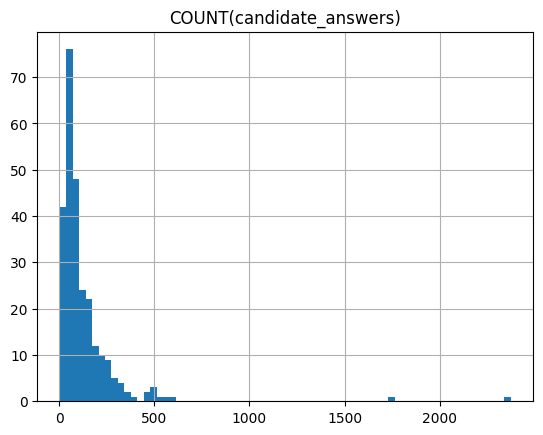

In [154]:
nat_ques_with_ans_exploded.groupby(
    [QUERY_COL]
    ).count()[[PASSAGE_COL]].reset_index().rename(
        {f"{PASSAGE_COL}": f"COUNT({PASSAGE_COL})"},
        axis=1
        ).hist(bins=70)

Distribution of the passage lengths


,candidate_ans_lens
count,34173.000000
mean,229.994938
std,571.971363
min,1.000000
25%,36.000000
50%,80.000000
75%,253.000000
max,47669.000000


<Axes: >

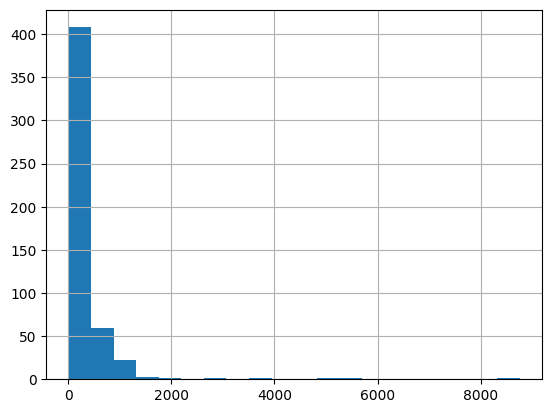

In [157]:
# Distribution of the passage string lengths
import matplotlib.pyplot as plt

nat_ques_with_ans_exploded['passage_lens'] = nat_ques_with_ans_exploded[PASSAGE_COL].str.len()


# Find out the str len of each candidate ans
nat_ques_with_ans_exploded['candidate_ans_lens'] = nat_ques_with_ans_exploded[
                                                              'candidate_answers'].str.len()

display_html(nat_ques_with_ans_exploded[['candidate_ans_lens']].describe())

nat_ques_with_ans_exploded.sample(500).reset_index()['candidate_ans_lens'].hist(bins=20)


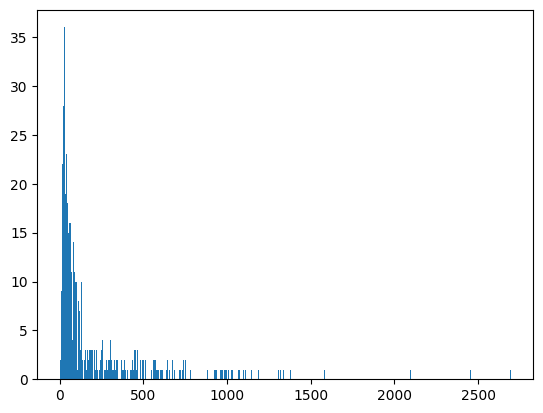

In [158]:
plt.hist(
    nat_ques_with_ans_exploded.sample(500).reset_index()['candidate_ans_lens'],
    bins=500
)

plt.show()

Looking at individual queries:

In [159]:
display_html(
    nat_ques_with_ans_exploded[
        nat_ques_with_ans_exploded[QUERY_COL] == "when did the medieval ages start and end"
    ][[QUERY_COL, PASSAGE_COL, 'passage_is_selected']].sort_values('passage_is_selected',
                                                                   ascending=False).head(20)
)

,question_text,candidate_answers,passage_is_selected


In [160]:
display_html(
    nat_ques_with_ans_exploded[
        nat_ques_with_ans_exploded[QUERY_COL] == "how many kv schools are there in india"
    ][[QUERY_COL, PASSAGE_COL, 'passage_is_selected']].sort_values('passage_is_selected',
                                                                   ascending=False).head(20)
)

,question_text,candidate_answers,passage_is_selected


## Sampling Negatives
> A 'Hard' Negative is any sample from the data that, for a given query, is 'not relevant' but the embedding still considers it relevant. i.e the query and that document are too near in the latent space of the embedding to be considered 'not related' or 'not relevant'

> The corollary to that is a 'Weak' negative, which is a passage that is not relevant and the default embedding can classify easily.

> Choosing the right negative sampling method is very important for achieving tangible improvements in the trained projection layer.

> Here we will extract both kinds of negatives and see the performance of the default OpenAI embedding in both cases

Before we sample negatives, we will filter by candidate string len, as it follows that really short answers are generally not relevant or useful for satisfying the query

In [63]:
# Stats around the candidate string len
nat_ques_with_ans_exploded['candidate_ans_lens'].describe()

count    34173.000000
mean       229.994938
std        571.971363
min          1.000000
25%         36.000000
50%         80.000000
75%        253.000000
max      47669.000000
Name: candidate_ans_lens, dtype: float64

In [170]:
# Percentage of samples with candidate ans lengths under some threshold
# 10, 50, 60, 65, 70, 10000
for i in [ 75, 80, 85, 90, 95, 100, 300, 500, 1000, 3000, 6000]:
    print("-----------------")
    print("Length Threshold: ", i)
    print("Percentage of samples under len thresh: ", round((nat_ques_with_ans_exploded['candidate_ans_lens'] < i).mean() * 100,2))
    print("-----------------")

-----------------
Length Threshold:  75
Percentage of samples under len thresh:  47.96
-----------------
-----------------
Length Threshold:  80
Percentage of samples under len thresh:  49.98
-----------------
-----------------
Length Threshold:  85
Percentage of samples under len thresh:  51.94
-----------------
-----------------
Length Threshold:  90
Percentage of samples under len thresh:  53.86
-----------------
-----------------
Length Threshold:  95
Percentage of samples under len thresh:  55.88
-----------------
-----------------
Length Threshold:  100
Percentage of samples under len thresh:  57.74
-----------------
-----------------
Length Threshold:  300
Percentage of samples under len thresh:  77.62
-----------------
-----------------
Length Threshold:  500
Percentage of samples under len thresh:  85.95
-----------------
-----------------
Length Threshold:  1000
Percentage of samples under len thresh:  96.31
-----------------
-----------------
Length Threshold:  3000
Percenta

In [171]:
# Taking a look at samples which are not the selected answer and
# below string len of 90

nat_ques_with_ans_exploded[
    (nat_ques_with_ans_exploded['candidate_ans_lens']<90)
    & (nat_ques_with_ans_exploded['candidate_answers'] !=
            nat_ques_with_ans_exploded['extracted_ans'])
].sort_values(
    'candidate_ans_lens',
    ascending=False
)[['candidate_answers', 'candidate_ans_lens']].head(100)

,candidate_answers,candidate_ans_lens
2237,To carry a firearm in someone else 's vehicle...,89
23102,The Big Cockatoo Mossman In front of...,89
31733,Shank 2 Electronic Arts XBLA 0000000...,89
1371,"4 numbers plus PB $10,000 $20,000 $30,...",89
11036,1967 Arizona State Bobby Winkles 11 --...,89
...,...,...
31380,Astropop PopCap Games XBLA 000000002...,89
21149,Ultra Street Fighter IV Capcom 00000...,89
11561,"Skyler Gisondo as Eric Bemis , the Hammonds '...",89
24791,"Release date December 15 , 1939 ( 1939 -...",89


In [172]:
# Taking a look at samples which are not the selected answer and
# below string len of 65

nat_ques_with_ans_exploded[
    (nat_ques_with_ans_exploded['candidate_ans_lens']<65)
    & (nat_ques_with_ans_exploded['candidate_answers'] !=
            nat_ques_with_ans_exploded['extracted_ans'])
].sort_values(
    'candidate_ans_lens',
    ascending=False
)[['candidate_answers', 'candidate_ans_lens']].head(100)

,candidate_answers,candidate_ans_lens
5816,Lieutenant commander Major or Commandant ...,64
20615,Term in office President Country Lost ...,64
32988,New animation systems for movement ( sliding ...,64
9557,"Allen Iverson ( Philadelphia 76ers , 2000 -- ...",64
20141,"33 1942 Minneapolis , MN Minnesota ( #...",64
...,...,...
5591,Día de Castilla y León Y ...,64
24439,Evanston Township St. Xavier Irvine ...,64
18474,2017 Nightcap Herself Episode : `` Gue...,64
1694,Founded by Ubaid bin Saeed and Maktum bin ...,64


In [174]:
# Mark all candidate passages which are below 1000 in length and is not the selected answer as False
# For the sake of demonstration, we will remove everything below 500 length
# in practice you want to keep as much of the data as you can!

nat_ques_with_ans_exploded['LEN_FILT'] = True
nat_ques_with_ans_exploded.loc[nat_ques_with_ans_exploded['candidate_ans_lens']<1000,'LEN_FILT'] = False

# nat_ques_with_ans_sample_exploded[~nat_ques_with_ans_sample_exploded['LEN_FILT']].shape[0]/666824

In [179]:
nat_ques_with_ans_exploded[nat_ques_with_ans_exploded['LEN_FILT']].groupby(
    ['question_text',
     'passage_is_selected',
     'LEN_FILT'
     ]).count()[['candidate_answers']].rename(columns={'candidate_answers':'count'})

count
question_text                                      passage_is_selected LEN_FILT       
80's movie about a kid in a spaceship              0                   True          2
a variable that measures an outcome or result o... 0                   True          1
an idiopathic condition associated with asprin ... 0                   True          1
any million dollar winners on who wants to be a... 0                   True         13
are pure metals made of atoms or ions              0                   True          3
...                                                                                ...
why did argentina attack the falklands/malvinas... 0                   True          5
                                                   1                   True          1
will xbox 360 disc work on xbox one                0                   True          3
world record for longest time keeping a balloon... 0                   True          2
xbox 360 games can you play on xbox one            0                   True          3

[266 rows x 1 columns]

In [69]:
nat_ques_with_ans_exploded[nat_ques_with_ans_exploded['LEN_FILT']].groupby(
    ['question_text',
     'passage_is_selected',
     'LEN_FILT'
     ]).count()[['candidate_answers']].describe()

,candidate_answers
count,266.000000
mean,4.736842
std,5.980339
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,36.000000


In [177]:
# eliminate too small candidates
nat_ques_with_ans_exploded_filt = nat_ques_with_ans_exploded[
                                        nat_ques_with_ans_exploded[
                                            'LEN_FILT']].copy()

# Save the filtered dataset
nat_ques_with_ans_exploded_filt.to_pickle(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/len_filt_no_blanks_html_cleaned_ans_extracted_exploded_30k_sample_v1.0-simplified_simplified-nq-train.pkl"
)

In [178]:
nat_ques_with_ans_exploded_filt.head(2)

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,extracted_ans,candidate_selected_id,candidate_answers,passage_is_selected,candidate_ans_lens,passage_lens,LEN_FILT
30,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,A common example of permission marketing is a...,54,Email marketing has evolved rapidly alongside...,0,1064,1064,True
40,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,A common example of permission marketing is a...,54,An exact return on investment can be tracked...,0,1642,1642,True


### 'Weak' Negatives:

In [71]:
nat_ques_with_ans_exploded.shape

(34173, 13)

In [188]:
NUM_WEAK_NEGATIVES = 2

def weak_negative_sampler(q_sample, orig_df, num_weak_negs=NUM_WEAK_NEGATIVES):
    query = q_sample[QUERY_COL].unique()[0]
    # Extracted Answer
    extracted_ans = q_sample['extracted_ans'].values[0]

    # Sample num_weak_negs candidate answers that are _not_ from the same query
    final_weak_neg_candidates = orig_df[
                                    orig_df[QUERY_COL] != query
                                ].sample(num_weak_negs)[PASSAGE_COL].tolist()
    return [extracted_ans, *final_weak_neg_candidates]


nat_ques_with_ans_exploded_weak_samples = nat_ques_with_ans_exploded_filt.groupby(
                                                QUERY_COL
                                            ).progress_apply(
                                                lambda x: weak_negative_sampler(
                                                            x,
                                                            orig_df=nat_ques_with_ans_exploded_filt,
                                                            num_weak_negs=NUM_WEAK_NEGATIVES)
                                                    ).reset_index().explode(0)

nat_ques_with_ans_exploded_weak_samples.reset_index(drop=True, inplace=True)
nat_ques_with_ans_exploded_weak_samples.columns = ['question_text', 'candidate_answers']

nat_ques_with_ans_exploded_weak_samples

100%|██████████| 223/223 [00:00<00:00, 682.84it/s]


,question_text,candidate_answers
0,80's movie about a kid in a spaceship,Flight of the Navigator is a 1986 American sc...
1,80's movie about a kid in a spaceship,McClure sought out and hired talented writers...
2,80's movie about a kid in a spaceship,The unique architecture of the retina and its...
3,a variable that measures an outcome or result ...,"In mathematical modeling , statistical modeli..."
4,a variable that measures an outcome or result ...,Black commentators criticised the film for it...
...,...,...
664,world record for longest time keeping a balloo...,"The current design was created in 1939 , and ..."
665,world record for longest time keeping a balloo...,Barlog explained that Kratos had to change hi...
666,xbox 360 games can you play on xbox one,The Xbox One gaming console has received upda...
667,xbox 360 games can you play on xbox one,"Following the December 1 , 2011 , vote by the..."


In [196]:
nat_ques_with_ans_exploded_weak_samples.shape

(669, 2)

In [197]:
def get_relv_label(candidates):
    labels = [0]*len(candidates) # Create a list of sample size i.e., 3
    labels[0] = 1  #Mark at the 0th index, and rest would be zeroes. Because first candidate_answer is the actual answer. So the labels with 0 will be considered weak_negatives later.
    return labels

nat_ques_with_ans_exploded_weak_samples["label"] = nat_ques_with_ans_exploded_weak_samples.groupby(
                                                        'question_text'
                                                    ).apply(get_relv_label).reset_index().explode(0).reset_index()[0]

In [201]:
nat_ques_with_ans_exploded_weak_samples.head(7)

,question_text,candidate_answers,label
0,80's movie about a kid in a spaceship,Flight of the Navigator is a 1986 American sc...,1
1,80's movie about a kid in a spaceship,McClure sought out and hired talented writers...,0
2,80's movie about a kid in a spaceship,The unique architecture of the retina and its...,0
3,a variable that measures an outcome or result ...,"In mathematical modeling , statistical modeli...",1
4,a variable that measures an outcome or result ...,Black commentators criticised the film for it...,0
5,a variable that measures an outcome or result ...,Many famous -- or soon - to - be-famous -- ac...,0
6,an idiopathic condition associated with asprin...,The cause of Reye syndrome is unknown . It us...,1


In [75]:
nat_ques_with_ans_exploded_weak_samples.to_pickle(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/weak_no_blanks_cleaned_ans_extracted_exploded_30k_sample_v1.0-simplified_simplified-nq-train.pkl"
)


### 'Hard' Negatives

In [207]:
# We will use a small but high performing Open-Source embedding model called
# 'gte-base' from the popular library 'sentence_transformers'.
# This is a light weight model but is still performant enough that we can use it
# for mining very-similar-but-not-relevant sentences from our data.

# Take a look at the MTEB (Massive Text Embedding Benchmark) Leaderboard:
# https://huggingface.co/spaces/mteb/leaderboard


In [208]:
# Load GTE Base
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('thenlper/gte-base')


In [212]:
nat_ques_with_ans_exploded['extracted_ans'].str.split().apply(len) #Show the length of each extracted_ans

0        67
1        67
2        67
3        65
4        67
         ..
34168    35
34169    35
34170    35
34171    35
34172    35
Name: extracted_ans, Length: 34173, dtype: int64

In [ ]:
nat_ques_with_ans_exploded['extracted_ans'].str.split().apply(len).describe()

count    34173.000000
mean       226.064495
std        371.853963
min          5.000000
25%         65.000000
50%        112.000000
75%        197.000000
max       2388.000000
Name: extracted_ans, dtype: float64

In [216]:
def hard_negative_sampler(q_sample, NUM_HARD_NEGATIVES, MODEL_BATCH_SIZE=128):
    # Get the query text from the input sample
    query = q_sample[QUERY_COL].unique()[0]
    query_emb = q_sample[QUERY_EMB_COL].values[0]

    # Calculate the length of each candidate answer and sort the sample by length in descending order
    q_sample['ans_lens'] = q_sample[PASSAGE_COL].str.len()
    q_sample.sort_values(by=['ans_lens'], ascending=False, inplace=True)

    # Extracted Answer
    extracted_ans = q_sample['extracted_ans'].values[0]

    # Select the top MODEL_BATCH_SIZE negative candidates to consider
    neg_candidates_to_consider, neg_candidate_embs_to_consider = [], []

    [(neg_candidates_to_consider.append(c),
      neg_candidate_embs_to_consider.append(c_emb))

     for _, (c, c_emb) in list(q_sample[            #Iterate through sample datafram and append neg_candidates, and their respective embeddings into initialized neg_candidates_to_consider, neg_candidate_embs_to_consider lists.
                        [PASSAGE_COL, PASSAGE_EMB_COL]
                    ].iterrows())

        # Only consider the candidate ans if its
        # NOT the selected answer itself
        if (c != extracted_ans)
    ][:MODEL_BATCH_SIZE]  #limit selection to defined MODEL_BATCH_SIZE

    # If there are more than 20 negative candidates, remove the bottom third
    # these are ordered by length, so really short ones may be eliminated,
    if len(neg_candidates_to_consider) > 20:
        neg_candidates_to_consider = neg_candidates_to_consider[:-q_sample.shape[0]//3]
        neg_candidate_embs_to_consider = neg_candidate_embs_to_consider[:-q_sample.shape[0]//3]

    # Create a list of query text and negative candidate answers to embed
    q_vs_neg_candidate_answers = [
                                    query,   # Query Itself
                                    *neg_candidates_to_consider   # candidate Answers
                                ]


    # Embed the query and negative candidate answers using the model
    embeddings = np.stack(
                    [
                        query_emb,
                        *neg_candidate_embs_to_consider
                    ]
                )


    # Calculate the cosine similarity between the query and each negative candidate answer
    scores = (embeddings[:1] @ embeddings[1:].T) * 100

    # Select the top NUM_HARD_NEGATIVES negative candidates based on cosine similarity
    only_neg_candidates = q_vs_neg_candidate_answers[1:] # is a list that contains the negative candidate answers. It excludes the first element, which is the query itself.
    final_neg_candidates = [only_neg_candidates[i]
                            for i
                            in np.argsort(
                                scores[0]
                            )[::-1][:NUM_HARD_NEGATIVES]
                           ]

    # Return a list of the extracted answer and the top NUM_HARD_NEGATIVES negative candidates
    return [extracted_ans, *final_neg_candidates]

In [217]:
# nat_ques_with_ans_exploded_filt

In [218]:
NEG_SAMPLER_EMBEDDING_MODEL_BATCH_SIZE = 512

def embed_sbert(passages, batch_size=NEG_SAMPLER_EMBEDDING_MODEL_BATCH_SIZE):
    return model.encode(passages,
                        show_progress_bar=True,
                        normalize_embeddings=True,
                        batch_size=batch_size)

In [222]:
# Embed all candidate passages, queries and extracted answers

# Embed Queries

query_embeddings = embed_sbert(
                        nat_ques_with_ans_exploded_filt[
                            QUERY_COL].unique().tolist(),
                        batch_size=512
                    )

# create pairs of unique queries (from the DataFrame) and their corresponding query embeddings (from the query_embeddings list).
#dict() is used to convert these pairs into a dictionary where the queries serve as keys, and the embeddings serve as values. This dictionary, q_emb_dict, now associates each unique query with its corresponding embedding.

q_emb_dict = dict(
                zip(
                    nat_ques_with_ans_exploded_filt[QUERY_COL].unique().tolist(),
                    query_embeddings
                    )
                )

#it uses a lambda function to look up the query in the q_emb_dict dictionary and retrieve the corresponding embedding.
# The resulting embeddings are then stored in a new column 'QUERY_EMB_COL' in the DataFrame, associating each query with its embedding.

nat_ques_with_ans_exploded_filt[QUERY_EMB_COL] = nat_ques_with_ans_exploded_filt[
                                                    QUERY_COL].progress_apply(
                                                        lambda x: q_emb_dict[x]
                                                        )

import gc;gc.collect()
torch.cuda.empty_cache()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1260/1260 [00:00<00:00, 542756.81it/s]


In [225]:
#Perform similar operations on passage_text too.
passage_embeddings = embed_sbert(
                        nat_ques_with_ans_exploded_filt[
                            PASSAGE_COL].unique().tolist(),
                        batch_size=256
                     )

p_emb_dict = dict(
                zip(
                    nat_ques_with_ans_exploded_filt[PASSAGE_COL].unique().tolist(),
                    passage_embeddings
                    )
                )

nat_ques_with_ans_exploded_filt[PASSAGE_EMB_COL] = nat_ques_with_ans_exploded_filt[
                                                    PASSAGE_COL].progress_apply(
                                                        lambda x: p_emb_dict[x]
                                                        )

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 1260/1260 [00:00<00:00, 561796.86it/s]


In [226]:
torch.cuda.empty_cache()

In [227]:
# We will keep the Top 2 Highest cosine similarity candidates
# from the candidate which were NOT selected for the answer

NUM_HARD_NEGATIVES = 2
nat_ques_with_ans_exploded_hard_samples = nat_ques_with_ans_exploded_filt.groupby(
                                                ['question_text'],
                                                # as_index=False
                                            ).progress_apply(
                                                lambda x: hard_negative_sampler(
                                                        x, NUM_HARD_NEGATIVES
                                                        )
                                                ).reset_index().explode(0)

nat_ques_with_ans_exploded_hard_samples.reset_index(drop=True, inplace=True)
nat_ques_with_ans_exploded_hard_samples.columns = ['question_text', 'candidate_answers']

100%|██████████| 223/223 [00:00<00:00, 413.06it/s]


In [228]:
nat_ques_with_ans_exploded_hard_samples

,question_text,candidate_answers
0,80's movie about a kid in a spaceship,Flight of the Navigator is a 1986 American sc...
1,80's movie about a kid in a spaceship,"On the night of July 4 , 1978 , in Fort Laude..."
2,80's movie about a kid in a spaceship,"The next morning , following a telepathic com..."
3,a variable that measures an outcome or result ...,"In mathematical modeling , statistical modeli..."
4,a variable that measures an outcome or result ...,"Extraneous variables , if included in a Regre..."
...,...,...
603,world record for longest time keeping a balloo...,\nDuration ( hhh : mm : ss )\tDate\tLocation\t...
604,world record for longest time keeping a balloo...,\nDuration ( dd : hh : mm : ss )\tDate\tLocati...
605,xbox 360 games can you play on xbox one,<P> The Xbox One gaming console has received u...
606,xbox 360 games can you play on xbox one,Not all Xbox 360 games will be supported ; 10...


In [229]:
def get_relv_label(candidates):
    labels = [0]*len(candidates)
    labels[0] = 1
    return labels

nat_ques_with_ans_exploded_hard_samples["label"] = nat_ques_with_ans_exploded_hard_samples.groupby(
                                                        'question_text'
                                                    ).apply(get_relv_label).reset_index().explode(0).reset_index()[0]

In [230]:
nat_ques_with_ans_exploded_hard_samples.to_pickle(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/hard_no_blanks_cleaned_ans_extracted_exploded_30k_sample_v1.0-simplified_simplified-nq-train.pkl"
)

In [231]:
len(set(nat_ques_with_ans_exploded_hard_samples[QUERY_COL].unique()))

223

In [232]:
len(set(nat_ques_with_ans_exploded_hard_samples[QUERY_COL].unique()).intersection(set(nat_ques_with_ans_exploded_weak_samples[QUERY_COL].unique())))

223

In [233]:
import gc;gc.collect()
torch.cuda.empty_cache()

Some answers have > 8192 tokens, which is the limit for the OpenAI embeddings model (text-embedding-ada-002)

In [234]:
# Load the tokenizer for the embedding model:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")

In [235]:
nat_ques_with_ans_exploded_hard_samples[
    'candidate_ans_len'] = nat_ques_with_ans_exploded_hard_samples[
                                'candidate_answers'].apply(
                                    lambda x: len(enc.encode(x))
                                    )

nat_ques_with_ans_exploded_weak_samples[
    'candidate_ans_len'] = nat_ques_with_ans_exploded_weak_samples[
                                'candidate_answers'].apply(
                                    lambda x: len(enc.encode(x))
                                    )

In [236]:
nat_ques_with_ans_exploded_hard_samples[
            nat_ques_with_ans_exploded_hard_samples[
                'candidate_ans_len']>8192
            ].shape

(3, 4)

In [238]:
nat_ques_with_ans_exploded_hard_samples[
            nat_ques_with_ans_exploded_hard_samples[
                'candidate_ans_len']>8192
            ]

,question_text,candidate_answers,label,candidate_ans_len
238,when did rangers last win the scottish cup,<Table> <Tr> <Th> Season </Th> <Th> Winner </T...,1,11756
601,will xbox 360 disc work on xbox one,\nTitle\tPublisher ( s )\tFormat\tXbox One X E...,0,17610
607,xbox 360 games can you play on xbox one,\nTitle\tPublisher ( s )\tFormat\tXbox One X E...,0,17617


In [237]:
nat_ques_with_ans_exploded_weak_samples[
            nat_ques_with_ans_exploded_weak_samples[
                'candidate_ans_len']>8192
            ].shape

(1, 4)

In [239]:
nat_ques_with_ans_exploded_weak_samples[
            nat_ques_with_ans_exploded_weak_samples[
                'candidate_ans_len']>8192
            ]

,question_text,candidate_answers,label,candidate_ans_len
241,what religious groups lived in the new england...,\nTitle\tPublisher ( s )\tFormat\tXbox One X E...,0,17617


In [240]:
# To handle such cases, we will simply truncate these few samples to the maximum
# token length

nat_ques_with_ans_exploded_hard_samples.loc[
    nat_ques_with_ans_exploded_hard_samples['candidate_ans_len']>8192,
    'candidate_answers'
    ] = nat_ques_with_ans_exploded_hard_samples[
            nat_ques_with_ans_exploded_hard_samples[
                'candidate_ans_len']>8192
            ]['candidate_answers'].apply(
                lambda x: enc.decode(enc.encode(x)[:8191])
                )


nat_ques_with_ans_exploded_weak_samples.loc[
    nat_ques_with_ans_exploded_weak_samples['candidate_ans_len']>8192,
    'candidate_answers'
    ] = nat_ques_with_ans_exploded_weak_samples[
            nat_ques_with_ans_exploded_weak_samples[
                'candidate_ans_len']>8192
            ]['candidate_answers'].apply(
                lambda x: enc.decode(enc.encode(x)[:8191])
                )

# 2. Embeddings:

> Embeddings are a form of text representation: a set of numbers that represent what the text means, and somehow capture the semantics of the text. These numbers are called text embeddings.
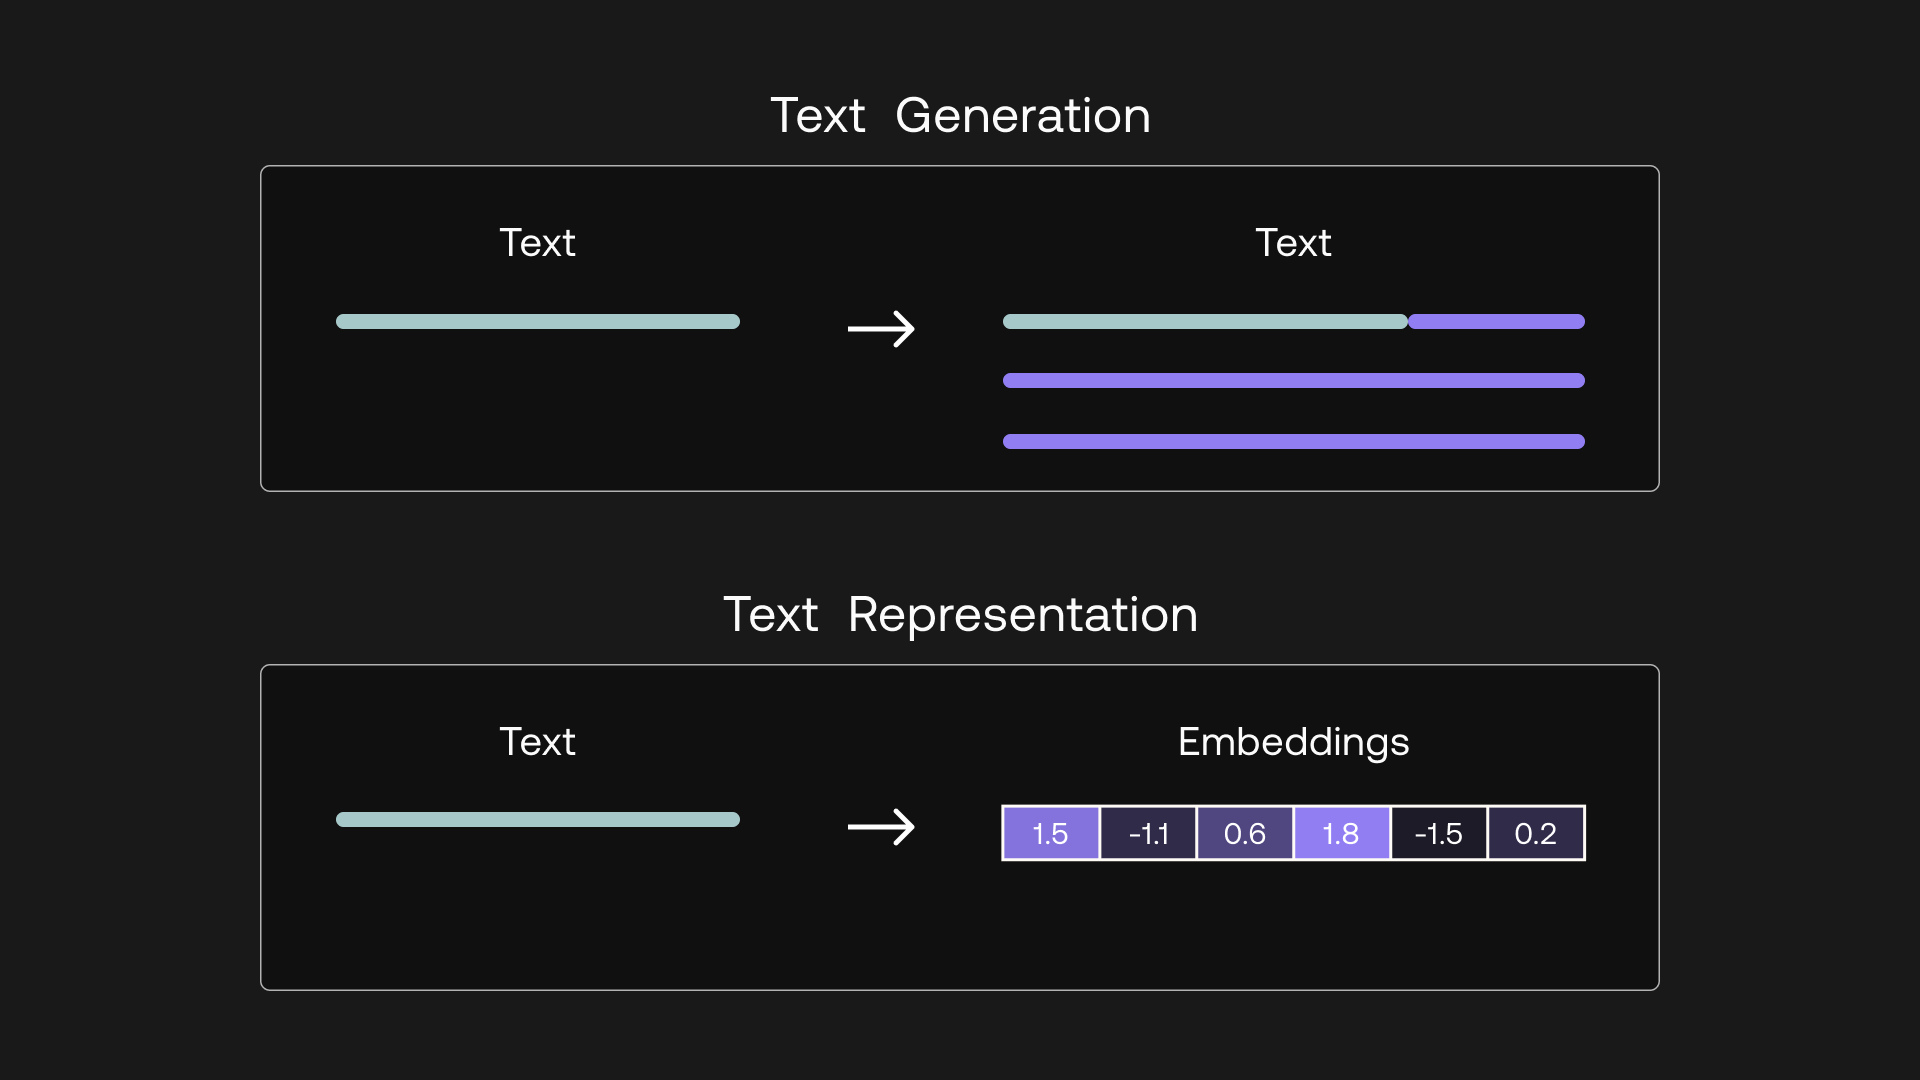

> Text Embeddings give you the ability to turn unstructured text data into a structured form. With embeddings, you can compare two or more pieces of text, be it single words, sentences, paragraphs, or even longer documents. And since these are sets of numbers, the ways you can process and extract insights from them are limited only by your imagination.

## 2.2 How To Get OpenAI Embeddings

OpenAI embeddings are a powerful tool for natural language processing tasks. They are pre-trained on a large corpus of text data and can be used to represent words, phrases, and sentences as high-dimensional vectors. Here are some reasons why you might want to use OpenAI embeddings:

- **Efficiency**: OpenAI embeddings are pre-trained, which means you don't need to train your own embeddings from scratch. This can save a lot of time and computational resources.

- **Accuracy**: OpenAI embeddings are trained on a large corpus of text data, which means they can capture complex relationships between words and phrases. This can lead to more accurate results in natural language processing tasks.

- **Flexibility**: OpenAI embeddings can be used for a wide range of natural language processing tasks, including text classification, sentiment analysis, and machine translation.


### 2.2.1 Get embeddings for queries and passages (Requires OpenAI API Key)

This code block contains functions to call the OpenAI Embedding API to generate embeddings for text data using a specified embedding model.

The `embedding_api_call` function takes in the text data, and embedding model name, and returns a tuple containing the generated embeddings, and the original data.

The `call_openai_api` function calls any OpenAI API for a list of arguments in parallel with retries and exponential backoff.

The `call_openai_api_batch` function calls the OpenAI API for a list of arguments in parallel with retries and exponential backoff, processing the arguments in batches. The code also defines constants for the batch size and the name of the embedding model to use.

In [242]:
openai.api_key = input("Please Enter Your OpenAI API key: ")

BATCH_SIZE = 10
EMBEDDING_MODEL = "text-embedding-ada-002"

def embedding_api_call(pr_id, data, embedding_model):
    """
    Calls the OpenAI Embedding API to generate embeddings for the given data using the specified embedding model.

    Args:
        pr_id (int): The ID of the pull request.
        data (str): The text data to generate embeddings for.
        embedding_model (str): The name of the embedding model to use.

    Returns:
        A tuple containing the pull request ID, the generated embeddings, and the original data.
    """
    embedding = openai.Embedding.create(
                input=data,
                engine=embedding_model
            )

    embedding = [e['embedding'] for e in embedding['data']]
    return pr_id, embedding, data

error_args = []
working_args = []

def call_openai_api_single(api_call_fn, call_fn_args, max_retries=5, backoff_factor=2):
    global error_args
    result = None
    retries = 0
    while retries < max_retries:
        try:
            result = api_call_fn(**call_fn_args)
            break
        except Exception as e:
            print(f"API error: {e}")
            error_args.append((call_fn_args, e))
            retries += 1
            if retries < max_retries:
                backoff_time = (2 ** retries) * backoff_factor + random.uniform(0, 1)
                print(f"Waiting {backoff_time:.2f} seconds before retrying...")
                time.sleep(backoff_time)
            else:
                print(f"Max retries ({max_retries}) exceeded, giving up.")
                raise Exception('Max Retries Exceeded Exception')
                # return call_fn_args
    return result


def call_openai_api(api_call_fn, args_list, max_retries=5, backoff_factor=2):
    """
    Call any OpenAI API for a list of arguments in parallel with retries and exponential backoff.

    Args:
        api_call_fn (function): The function to call for each set of arguments.
        args_list (list): A list of tuples or lists, where each tuple or list contains the arguments to be passed to api_call_fn.
        max_retries (int): The maximum number of retries in case of API errors.
        backoff_factor (float): The factor by which the waiting time between retries should increase.

    Yields:
        The results of each API call, as returned by api_call_fn.
    """
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for args in args_list:
            future = executor.submit(call_openai_api_single, api_call_fn, args, max_retries, backoff_factor)
            futures.append(future)
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            yield result


def call_openai_api_batch(api_call_fn, args_list, batch_size=1, max_retries=5, backoff_factor=2):
    """
    Call any OpenAI API for a list of arguments in parallel with retries and exponential backoff.

    Args:
        api_call_fn (function): The function to call for each set of arguments.
        args_list (list): A list of tuples or lists, where each tuple or list contains the arguments to be passed to api_call_fn.
        batch_size (int): The number of arguments to process in each batch.
        max_retries (int): The maximum number of retries in case of API errors.
        backoff_factor (float): The factor by which the waiting time between retries should increase.

    Returns:
        The results of each API call, as returned by api_call_fn, in order of pr_id.
    """
    results = {}
    num_batches = math.ceil(len(args_list)/batch_size)
    ctr = 1
    end_chr = '\r'
    for i in tqdm_notebook(range(0, len(args_list), batch_size)):
        if ctr == num_batches:
            end_chr = '\n'
        print(f"Processing batch {ctr} of {num_batches} | {len(args_list)} prompts for batch size {batch_size}", end=end_chr)
        batch_args = args_list[i:i+batch_size]
        for result in call_openai_api(api_call_fn, batch_args, max_retries, backoff_factor):
            pr_id = result[0]
            results[pr_id] = result[1:]
        ctr += 1
    return [(i, results[i]) for i in range(len(args_list))]



In [ ]:
embedding_model = "text-embedding-ada-002"

# Embed the questions and turns
api_call_fn = embedding_api_call

def embed(prompts):
    args_list = [dict(pr_id=pr_id,
                      data=prompt,
                      embedding_model=embedding_model)
                 for pr_id, prompt in enumerate(prompts)]

    return call_openai_api_batch(api_call_fn,
                                 args_list,
                                 batch_size=500,
                                 max_retries=5,
                                 backoff_factor=2)




In [241]:
# For the Hard Negative Samples:

# Embed All Queries
query_embeddings = embed(
                        nat_ques_with_ans_exploded_hard_samples[QUERY_COL].unique().tolist()
                    )
q_emb_dict = dict(zip(nat_ques_with_ans_exploded_hard_samples[QUERY_COL].unique().tolist(), query_embeddings))

nat_ques_with_ans_exploded_hard_samples[QUERY_EMB_COL] = nat_ques_with_ans_exploded_hard_samples[QUERY_COL].apply(lambda x: q_emb_dict[x][1][0][0])

# Embed All Passages
passage_embeddings = embed(nat_ques_with_ans_exploded_hard_samples[PASSAGE_COL].unique().tolist())
p_emb_dict = dict(zip(nat_ques_with_ans_exploded_hard_samples[PASSAGE_COL].unique().tolist(), passage_embeddings))

nat_ques_with_ans_exploded_hard_samples[PASSAGE_EMB_COL] = nat_ques_with_ans_exploded_hard_samples[PASSAGE_COL].apply(lambda x: p_emb_dict[x][1][0][0])

In [ ]:
# For the Weak Negative Samples:

# Embed All Queries
query_embeddings = embed(
                        nat_ques_with_ans_exploded_weak_samples[QUERY_COL].unique().tolist()
                    )
q_emb_dict = dict(zip(nat_ques_with_ans_exploded_weak_samples[QUERY_COL].unique().tolist(), query_embeddings))

nat_ques_with_ans_exploded_weak_samples[QUERY_EMB_COL] = nat_ques_with_ans_exploded_weak_samples[QUERY_COL].apply(lambda x: q_emb_dict[x][1][0][0])

# Embed All Passages
passage_embeddings = embed(nat_ques_with_ans_exploded_weak_samples[PASSAGE_COL].unique().tolist())
p_emb_dict = dict(zip(nat_ques_with_ans_exploded_weak_samples[PASSAGE_COL].unique().tolist(), passage_embeddings))

nat_ques_with_ans_exploded_weak_samples[PASSAGE_EMB_COL] = nat_ques_with_ans_exploded_weak_samples[PASSAGE_COL].apply(lambda x: p_emb_dict[x][1][0][0])

### Save the embedded negative sampled datasets

In [ ]:
# I
# nat_ques_with_ans_exploded_weak_samples.to_parquet(
#     f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/weak_no_blanks_cleaned_ans_extracted_exploded_30k_sample_v1.0-simplified_simplified-nq-train.parquet"
# )

# nat_ques_with_ans_exploded_hard_samples.to_parquet(
#     f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/hard_no_blanks_cleaned_ans_extracted_exploded_30k_sample_v1.0-simplified_simplified-nq-train.parquet"
# )

In [ ]:
PREPROCESSED_DATASETS_PATH

In [ ]:
nat_ques_with_ans_exploded_weak_samples= pd.read_parquet(
    f"{PREPROCESSED_DATASETS_PATH}/small/natural_questions/weak_no_blanks_cleaned_ans_extracted_exploded_30k_sample_v1.0-simplified_simplified-nq-train.parquet"
)

nat_ques_with_ans_exploded_hard_samples= pd.read_parquet(
    f"{PREPROCESSED_DATASETS_PATH}/small/natural_questions/hard_no_blanks_cleaned_ans_extracted_exploded_30k_sample_v1.0-simplified_simplified-nq-train.parquet"
)

In [ ]:
nat_ques_with_ans_exploded_hard_samples[nat_ques_with_ans_exploded_hard_samples[QUERY_EMB_COL].apply(lambda x: np.isnan(x[0]))].shape

In [ ]:
nat_ques_with_ans_exploded_hard_samples[nat_ques_with_ans_exploded_hard_samples[PASSAGE_EMB_COL].apply(lambda x: np.isnan(x[0]))].shape

## Train Test Split
Split Embedded Negative Sampled Datasets into train and test datasets:

In [ ]:
# We take a small peak at our dataset now:

nat_ques_with_ans_exploded_hard_samples.head(5)

We can see that each question has  :
    
    . upto two candidates labelled as 0 (negative/ irrelevant) and
    . only one labelled as 1 (positive/ relevant)

If we simply split this data randomly, we will introduce "leakage" into the test set i.e. some queries will be commonly present in our train set as well as out test set!


>We _really_ dont want that

In [ ]:
def split_into_train_test_by_query(df, test_size=0.3):
    # Split the dataset based on queries:
    all_queries = df[QUERY_COL].unique()
    train_queries, test_queries = train_test_split(all_queries,
                                                   test_size=test_size,
                                                   random_state=42)

    train_df = df[df[QUERY_COL].isin(train_queries)]

    test_df = df[df[QUERY_COL].isin(test_queries)]
    return train_df, test_df


In [ ]:
train_hard_sample_df, test_hard_sample_df = split_into_train_test_by_query(
                                                nat_ques_with_ans_exploded_hard_samples,
                                                test_size=0.3
                                            )

train_weak_sample_df, test_weak_sample_df = split_into_train_test_by_query(
                                                nat_ques_with_ans_exploded_weak_samples,
                                                test_size=0.3
                                            )

In [ ]:
train_hard_sample_df.shape, test_hard_sample_df.shape

((3937, 6), (1695, 6))

In [ ]:
train_weak_sample_df.shape, test_weak_sample_df.shape

((4344, 6), (1863, 6))

In [ ]:
# Save the preprocessed labelled, negative sampled, cleaned,
# filtered dataset for furthur use:

train_hard_sample_df.to_parquet(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/preprocessed_labelled_train_hard_sample_df.parquet"
    )

test_hard_sample_df.to_parquet(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/preprocessed_labelled_test_hard_sample_df.parquet"
    )



train_weak_sample_df.to_parquet(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/preprocessed_labelled_train_weak_sample_df.parquet"
    )

test_weak_sample_df.to_parquet(
    f"{FINETUNING_EMBEDDINGS_PATH}/datasets/natural_questions/preprocessed_labelled_test_weak_sample_df.parquet"
    )


### Performance of Default Embeddings:

> To get a visual representation of the 'behaviour' or performance of the default embeddings, we plot a distribution of cosine similarity.

> The graphs show how much the overlap there is between the distribution of cosine similarities for similar and dissimilar pairs. If there is a high amount of overlap, that means there are some dissimilar pairs with greater cosine similarity than some similar pairs.

> The accuracy computed here is the accuracy of a simple rule that predicts 'similar (1)' if the cosine similarity is above some threshold X and otherwise predicts 'dissimilar (0)'.

In [ ]:
def accuracy_and_se_and_thresh(cosine_similarity: float, labeled_similarity: int) -> Tuple[float]:
    accuracies = []
    for threshold_thousandths in range(-1000, 1000, 1):
        threshold = threshold_thousandths / 1000
        total = 0
        correct = 0
        for cs, ls in zip(cosine_similarity, labeled_similarity):
            total += 1
            if cs > threshold:
                prediction = 1
            else:
                prediction = 0
            if prediction == ls:
                correct += 1
        accuracy = correct / total
        accuracies.append(accuracy)
    max_i = np.argmax(accuracies)
    best_threshold = np.arange(-1000, 1000, 1)[max_i] / 1000.
    a = accuracies[max_i]
    n = len(cosine_similarity)
    standard_error = (a * (1 - a) / n) ** 0.5  # standard error of binomial
    return a, standard_error, best_threshold

#### Performance on Weak Negative Samples

In [ ]:
train_weak_sample_df['dataset'] = 'train'
test_weak_sample_df['dataset'] = 'test'

trts_weak_neg_df = pd.concat([train_weak_sample_df, test_weak_sample_df])

# Get Cosine Similarity of default embedding with positive and negative pairs
trts_weak_neg_df['cosine_similarity'] = trts_weak_neg_df.apply(
                                lambda x: cosine_similarity(
                                                x[QUERY_EMB_COL],
                                                x[PASSAGE_EMB_COL]
                                            ),
                                axis=1)


# check that training and test sets are balanced
px.histogram(
    trts_weak_neg_df,
    x="cosine_similarity",
    color="label",
    barmode="overlay",
    width=500,
    facet_row="dataset",
    nbins=200
).show()

for dataset in ["train", "test"]:
    data = trts_weak_neg_df[trts_weak_neg_df["dataset"] == dataset]
    a, se, thresh = accuracy_and_se_and_thresh(data["cosine_similarity"], data["label"])
    print(f"{dataset} accuracy: {a:0.1%} ± {1.96 * se:0.1%} | Thresh: {thresh}")

train accuracy: 97.4% ± 0.5% | Thresh: 0.735
test accuracy: 97.8% ± 0.7% | Thresh: 0.736


#### Performance on Hard Negative Samples

In [ ]:
train_hard_sample_df['dataset'] = 'train'
test_hard_sample_df['dataset'] = 'test'

trts_hard_neg_df = pd.concat([train_hard_sample_df, test_hard_sample_df])

# Get Cosine Similarity of default embedding with positive and negative pairs
trts_hard_neg_df['cosine_similarity'] = trts_hard_neg_df.apply(
                                lambda x: cosine_similarity(
                                                x[QUERY_EMB_COL],
                                                x[PASSAGE_EMB_COL]
                                            ),
                                axis=1)


# check that training and test sets are balanced
px.histogram(
    trts_hard_neg_df,
    x="cosine_similarity",
    color="label",
    barmode="overlay",
    width=500,
    facet_row="dataset",
    nbins=200
).show()

for dataset in ["train", "test"]:
    data = trts_hard_neg_df[trts_hard_neg_df["dataset"] == dataset]
    a, se, thresh = accuracy_and_se_and_thresh(data["cosine_similarity"], data["label"])
    print(f"{dataset} accuracy: {a:0.1%} ± {1.96 * se:0.1%} | Thresh: {thresh}")

train accuracy: 68.0% ± 1.5% | Thresh: 0.847
test accuracy: 69.0% ± 2.2% | Thresh: 0.845


> From the above graphs, its clear that the default OpenAI embedding does a _very_ good job at predicting if a document is irrelevant if the negatives are sampled randomly!

> Not so much, if the negatives are sampled based on semantic similarity from another small model!

> Thus, we will use the hard negatives for training furthur ..

### Load the pre-saved preprocessed, cleaned, embedded, hard negative sampled datasets:

In [ ]:
!ls {PREPROCESSED_DATASETS_PATH}/natural_questions/

ls: cannot access '/content/drive/MyDrive/WORKSHOP/datasets/natural_questions/': No such file or directory


In [ ]:
# # Load pre processed train test split datasets:

# train_hard_sample_df = pd.read_parquet(
#     f"{PREPROCESSED_DATASETS_PATH}/large/preprocessed_labelled_train_hard_sample_df.parquet"
#     )

# test_hard_sample_df = pd.read_parquet(
#     f"{PREPROCESSED_DATASETS_PATH}/large/preprocessed_labelled_test_hard_sample_df.parquet"
#     )

# train_hard_sample_df.shape, test_hard_sample_df.shape

## 3.2 Visualizing the Embedding Latent Space:

> We will visualize the embeddings in 3D to see how relevant and non relevant samples are clustered by the embedding

### Visualize Embeddings in the context of retrieval:


In [ ]:
# Selecting a small sample to visualize

vis_sample = train_hard_sample_df.head(100)


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA

def visualize_queries_and_passages_in_3d(vis_sample, query_emb_col, passage_emb_col):
    vis_sample['marker_size'] = 200

    # Train PCA on all query and emb
    pca = PCA(n_components=3)
    pca.fit(np.vstack([vis_sample[query_emb_col].tolist(), vis_sample[passage_emb_col].tolist()]))

    # Get PCA emb for each query and doc
    vis_sample['question_text_PCA'] = pca.transform(vis_sample[query_emb_col].values.tolist()).tolist()
    vis_sample['candidate_answers_PCA'] = pca.transform(vis_sample[passage_emb_col].values.tolist()).tolist()

    vis_sample[['question_text_PCA1',
                'question_text_PCA2',
                'question_text_PCA3'
                ]] = pd.DataFrame(vis_sample['question_text_PCA'].tolist(), index=vis_sample.index)

    vis_sample[['candidate_answers_PCA1',
                'candidate_answers_PCA2',
                'candidate_answers_PCA3'
                ]] = pd.DataFrame(vis_sample['candidate_answers_PCA'].tolist(), index=vis_sample.index)

    vis_embs = np.vstack([vis_sample['question_text_PCA'].tolist(),
                        vis_sample['candidate_answers_PCA'].tolist()])

    vis_embs = pd.DataFrame(vis_embs.tolist(),
                            columns=['PCA1', 'PCA2', 'PCA3'],
                        )

    vis_embs['marker_size'] = 100

    vis_embs['text'] = np.hstack([vis_sample['question_text'].tolist(),
                                    vis_sample['candidate_answers'].tolist()])

    vis_embs['label'] = np.hstack([vis_sample['label'].tolist(),
                                    vis_sample['label'].tolist()])

    vis_embs['query_or_passage'] = vis_embs['text'].apply(lambda x: 1 if x in vis_sample['question_text'].values else 0)

    vis_embs['text'] = vis_embs['text'].apply(lambda x: x[:50])

    vis_embs['text'] = vis_embs.apply(lambda x: f"QUERY: {x['text']}" if x['query_or_passage'] else f"PASSAGE: {x['text']}", axis=1)

    # Plot all points on a 3D graph
    fig = px.scatter_3d(vis_embs,
                        x='PCA1',
                        y='PCA2',
                        z='PCA3',
                        color='query_or_passage',
                        hover_name='text',
                        symbol='label',
                        size='marker_size',
                        opacity=0.8
                        )

    # # fig.update_traces()

    # Draw a line between the query and passage if the 'label' column for the specific query and passage is 1
    for i, row in vis_sample.iterrows():
        if row['label'] == 1:
            fig.add_trace(
                go.Scatter3d(
                    x=[row['question_text_PCA'][0], row['candidate_answers_PCA'][0]],
                    y=[row['question_text_PCA'][1], row['candidate_answers_PCA'][1]],
                    z=[row['question_text_PCA'][2], row['candidate_answers_PCA'][2]],
                    mode='lines',
                    line=dict(color='red', width=2)
                )
            )


    fig.show()

In [ ]:
# Visualize the Default Embedding:

visualize_queries_and_passages_in_3d(vis_sample,
                                     query_emb_col=QUERY_EMB_COL,
                                     passage_emb_col=PASSAGE_EMB_COL)

In [ ]:
#Yellow dots: query; blue: Candidate Answers
# Square dot: Negative sample
# Circle Dot: Positive sample
# Blue lines: Showing position of data point
# Red lines:  Showing pair
#

In [ ]:
# T-SNE, U-Map and other work better

# 4. Projection:

## Training Projection Layer

Load Pre-saved Train/Test splits

In [ ]:
PREPROCESSED_DATASETS_PATH

'/content/drive/MyDrive/WORKSHOP/datasets'

In [ ]:
# As any good cooking show host does, I have preprocessed, soaked and fermented
# the data overnight for us to use in training :)


train_hard_sample_df = pd.read_parquet(
    f"{PREPROCESSED_DATASETS_PATH}/large/natural_questions/preprocessed_labelled_train_hard_sample_df.parquet"
    )

test_hard_sample_df = pd.read_parquet(
    f"{PREPROCESSED_DATASETS_PATH}/large/natural_questions/preprocessed_labelled_test_hard_sample_df.parquet"
    )

train_hard_sample_df.shape, test_hard_sample_df.shape

((11034, 7), (4947, 7))

In [ ]:
# Prepare the train-test dataset

train_hard_sample_df['dataset'] = 'train'
test_hard_sample_df['dataset'] = 'test'

trts_df = pd.concat(
                [train_hard_sample_df,
                 test_hard_sample_df]
            )

# Get Cosine Similarity of default embedding with positive and negative pairs
trts_df['cosine_similarity'] = trts_df.apply(
                                lambda x: cosine_similarity(
                                                x[QUERY_EMB_COL],
                                                x[PASSAGE_EMB_COL]
                                            ),
                                axis=1)

trts_df

,question_text,candidate_answers,label,candidate_ans_len,question_text_EMB,candidate_answers_EMB,NEG_FILT,dataset,cosine_similarity
0,. in gothic architecture the main purpose of t...,"The flying buttress ( arc - boutant , arch bu...",1,80,"[-0.026254886761307716, -0.007544751279056072,...","[-0.031434886157512665, 0.013343453407287598, ...",True,train,0.857982
1,. in gothic architecture the main purpose of t...,By relieving the load - bearing walls of exce...,0,198,"[-0.026254886761307716, -0.007544751279056072,...","[-0.01564301736652851, 0.0045648058876395226, ...",True,train,0.877325
2,. in gothic architecture the main purpose of t...,"As a lateral - support system , the flying bu...",0,227,"[-0.026254886761307716, -0.007544751279056072,...","[-0.013611356727778912, 0.009083249606192112, ...",True,train,0.871830
4,1 coulomb charge is equal to how many electrons,Since the charge of one electron is known to ...,1,96,"[0.02806258015334606, -0.0007646479643881321, ...","[0.013541552238166332, -0.007421812508255243, ...",True,train,0.872617
5,1 coulomb charge is equal to how many electrons,One coulomb is the magnitude ( absolute valu...,0,250,"[0.02806258015334606, -0.0007646479643881321, ...","[0.017166581004858017, 0.006878127809613943, 0...",True,train,0.891198
...,...,...,...,...,...,...,...,...,...
6638,www is the internet protocol used to transfer ...,The World Wide Web ( `` WWW '' or simply the ...,0,84,"[0.02260005474090576, 0.013813390396535397, 0....","[0.004085301887243986, -0.0008504602592438459,...",True,test,0.825909
6639,www is the internet protocol used to transfer ...,Early websites intermingled links for both th...,0,120,"[0.02260005474090576, 0.013813390396535397, 0....","[-0.0019630249589681625, -0.001118409796617925...",True,test,0.823730
6641,you are my sunshine my only sunshine movie,Take Me Back to Oklahoma ( 1940 ) - sung by ...,1,67,"[-0.025785792618989944, -0.024457033723592758,...","[-0.02845994010567665, -0.04275671765208244, -...",True,test,0.754734
6642,you are my sunshine my only sunshine movie,`` You Are My Sunshine '' is a popular song w...,0,73,"[-0.025785792618989944, -0.024457033723592758,...","[-0.01863555982708931, -0.0013575366465374827,...",True,test,0.832844


#### Make Dataloader

In [ ]:
def tensors_from_dataframe(
    df: pd.DataFrame,
    embedding_column_1: str,
    embedding_column_2: str,
    similarity_label_column: str,
) -> Tuple[torch.tensor]:
    e1 = np.stack(np.array(df[embedding_column_1].values))
    e2 = np.stack(np.array(df[embedding_column_2].values))
    s = np.stack(np.array(df[similarity_label_column].astype("float").values))

    e1 = torch.from_numpy(e1).float()
    e2 = torch.from_numpy(e2).float()
    s = torch.from_numpy(s).float()

    if use_cuda:
        return e1.cuda(), e2.cuda(), s.cuda()
    else:
        return e1, e2, s


# Applies a bias matrix to corresponding embeddings
def embedding_multiplied_by_matrix(
    embedding: List[float], matrix: torch.Tensor
) -> np.ndarray:
    embedding_tensor = torch.tensor(embedding, device='cuda' if use_cuda else 'cpu').float()
    modified_embedding = embedding_tensor @ matrix
    return modified_embedding.detach().cpu().numpy()


# compute custom embeddings and new cosine similarities
def apply_matrix_to_embeddings_dataframe(matrix: torch.Tensor, df: pd.DataFrame):
    df[f"{QUERY_EMB_COL}_custom"] = embedding_multiplied_by_matrix(
                                            np.stack(
                                                df[QUERY_EMB_COL].values),
                                            matrix
                                        ).tolist()

    df[f"{PASSAGE_EMB_COL}_custom"] = embedding_multiplied_by_matrix(
                                            np.stack(
                                                df[PASSAGE_EMB_COL].values),
                                            matrix
                                        ).tolist()

    df["cosine_similarity_custom"] = df.apply(
        lambda row: cosine_similarity(
            row[f"{QUERY_EMB_COL}_custom"],
            row[f"{PASSAGE_EMB_COL}_custom"]
        ),
        axis=1,
    )

### Start Training

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR


def tensors_from_dataframe(
    df: pd.DataFrame,
    embedding_column_1: str = "query_embedding",
    embedding_column_2: str = "passage_embedding",
    similarity_label_column: str = "label",
) -> Tuple[torch.tensor]:
    """Convert dataframe to torch tensors."""
    e1 = np.stack(np.array(df[embedding_column_1].values))
    e2 = np.stack(np.array(df[embedding_column_2].values))
    s = np.stack(np.array(df[similarity_label_column].astype("float").values))

    e1 = torch.from_numpy(e1).float()
    e2 = torch.from_numpy(e2).float()
    s = torch.from_numpy(s).float()

    if use_cuda:
        return e1.cuda(), e2.cuda(), s.cuda()
    else:
        return e1, e2, s


def create_train_loader(e1_train, e2_train, s_train, batch_size):
    """Create train loader."""
    dataset = torch.utils.data.TensorDataset(e1_train, e2_train, s_train)
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    return train_loader


def initialize_matrix(df, modified_embedding_length):
    """Initialize projection matrix."""
    embedding_length = len(df[QUERY_EMB_COL].values[0])
    matrix = torch.randn(
        embedding_length,
        modified_embedding_length,
        requires_grad=True,
        device='cuda' if use_cuda else 'cpu',
    )
    matrix.retain_grad()  # retain gradients for non-leaf tensor
    return matrix


def initialize_optimizer_and_scheduler(matrix, learning_rate, max_epochs, train_loader):
    """Initialize optimizer and lr scheduler."""
    optimizer = torch.optim.SGD(params=[matrix], lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=max_epochs,
        steps_per_epoch=len(train_loader),
    )
    return optimizer, scheduler


def train_model(
    max_epochs,
    print_progress,
    optimizer,
    scheduler,
    matrix,
    train_loader,
    e1_test,
    e2_test,
    s_test,
    df,
    run_id,
    modified_embedding_length,
    batch_size,
    learning_rate,
    lr_decay,
    dropout_fraction,
    save_results,
):
    """Train the model and record results."""
    epochs, types, losses, accuracies, matrices, lrs = [], [], [], [], [], []
    for epoch in tqdm_notebook(range(0, max_epochs)):
        # iterate through training dataloader
        for a, b, actual_similarity in tqdm_notebook(train_loader):
            optimizer.zero_grad()  # instead of manually zeroing the gradients

            # generate prediction
            predicted_similarity = model(a, b, matrix)

            # get loss and perform backpropagation
            loss = mse_loss(
                predicted_similarity, actual_similarity.to('cuda' if use_cuda else 'cpu')
            )
            loss.backward()

            # update the weights
            optimizer.step()

            # update lr scheduler
            scheduler.step()

        # record learning rate
        lrs.append(scheduler.get_last_lr()[0])


        # calculate test loss
        test_predictions = model(e1_test, e2_test, matrix)
        test_loss = mse_loss(test_predictions, s_test.to('cuda' if use_cuda else 'cpu'))

        # compute custom embeddings and new cosine similarities
        apply_matrix_to_embeddings_dataframe(matrix, df)

        # calculate test accuracy
        for dataset in ["train", "test"]:
            data = df[df["dataset"] == dataset]
            a, se, thresh = accuracy_and_se_and_thresh(
                data["cosine_similarity_custom"], data["label"]
            )

            # record results of each epoch
            epochs.append(epoch)
            types.append(dataset)
            losses.append(loss.item() if dataset == "train" else test_loss.item())
            accuracies.append(a)
            matrices.append(matrix.detach().cpu().numpy())

            # optionally print accuracies
            if print_progress is True:
                print(
                    f"Epoch {epoch}/{max_epochs}: {dataset} accuracy: {a:0.1%} ± {1.96 * se:0.1%}, lr: {lrs[-1]}, thresh: {thresh}"
                )

    data = pd.DataFrame(
        {"epoch": epochs, "type": types, "loss": losses, "accuracy": accuracies}
    )
    data["run_id"] = run_id
    data["modified_embedding_length"] = modified_embedding_length
    data["batch_size"] = batch_size
    data["max_epochs"] = max_epochs
    data["learning_rate"] = learning_rate
    data["lr_decay"] = lr_decay
    data["dropout_fraction"] = dropout_fraction
    data[
        "matrix"
    ] = matrices  # saving every single matrix can get big; feel free to delete/change
    if save_results is True:
        data.to_csv(f"{run_id}_optimization_results.csv", index=False)

    return data


def model(embedding_1, embedding_2, matrix, dropout_fraction=0.1):
    """Define model (similarity of projected embeddings)."""
    e1 = torch.nn.functional.dropout(embedding_1, p=dropout_fraction).to('cuda' if use_cuda else 'cpu')  #Query
    e2 = torch.nn.functional.dropout(embedding_2, p=dropout_fraction).to('cuda' if use_cuda else 'cpu') #Candidate answers
    modified_embedding_1 = e1 @ matrix  # @ is matrix multiplication
    modified_embedding_2 = e2 @ matrix
    similarity = torch.nn.functional.cosine_similarity(
        modified_embedding_1, modified_embedding_2
    )
    return similarity


def mse_loss(predictions, targets):
    """Define loss function to minimize."""
    difference = predictions - targets
    return torch.sum(difference * difference) / difference.numel()



def optimize_matrix(
    modified_embedding_length: int = 1024,
    batch_size: int = 100,
    max_epochs: int = 100,
    learning_rate: float = 10.0,
    dropout_fraction: float = 0.1,
    lr_decay: float = 0.3,
    df: pd.DataFrame = None,
    print_progress: bool = True,
    save_results: bool = True,
) -> pd.DataFrame:
    """Return matrix optimized to minimize loss on training data."""
    run_id = random.randint(0, 2 ** 31 - 1)  # (range is arbitrary)

    # convert from dataframe to torch tensors
    e1_train, e2_train, s_train = tensors_from_dataframe(
                                    df[df['dataset'] == 'train'],
                                    embedding_column_1=QUERY_EMB_COL,
                                    embedding_column_2=PASSAGE_EMB_COL,
                                    similarity_label_column='label'
                                  )

    e1_test, e2_test, s_test = tensors_from_dataframe(
                                    df[df['dataset'] == 'test'],
                                    embedding_column_1=QUERY_EMB_COL,
                                    embedding_column_2=PASSAGE_EMB_COL,
                                    similarity_label_column='label'
                                )

    # create dataset and loader
    train_loader = create_train_loader(e1_train, e2_train, s_train, batch_size)

    # initialize projection matrix
    matrix = initialize_matrix(df, modified_embedding_length)

    # initialize optimizer and lr scheduler
    optimizer, scheduler = initialize_optimizer_and_scheduler(
        matrix, learning_rate, max_epochs, train_loader
    )

    # train the model and record results
    data = train_model(
        max_epochs,
        print_progress,
        optimizer,
        scheduler,
        matrix,
        train_loader,
        e1_test,
        e2_test,
        s_test,
        df,
        run_id,
        modified_embedding_length,
        batch_size,
        learning_rate,
        lr_decay,
        dropout_fraction,
        save_results,
    )

    return data


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# example hyperparameter search
results = []
max_epochs = 20
dropout_fraction = 0.1
lr_decay = 0.8


for batch_size, learning_rate in [(1000, 1000)]:
    print("batch_size, learning_rate")
    print(batch_size, learning_rate)
    print()
    result = optimize_matrix(
        df=trts_df,
        batch_size=batch_size,
        learning_rate=learning_rate,
        max_epochs=max_epochs,
        dropout_fraction=dropout_fraction,
        lr_decay=lr_decay,
        save_results=False,
    )
    results.append(result)


batch_size, learning_rate
1000 1000



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0/20: train accuracy: 66.1% ± 0.9%, lr: 106.08900519038662, thresh: 0.642
Epoch 0/20: test accuracy: 66.6% ± 1.3%, lr: 106.08900519038662, thresh: 0.612


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/20: train accuracy: 66.0% ± 0.9%, lr: 286.15703489881764, thresh: 0.67
Epoch 1/20: test accuracy: 66.2% ± 1.3%, lr: 286.15703489881764, thresh: 0.677


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/20: train accuracy: 65.8% ± 0.9%, lr: 530.6186018335296, thresh: 0.532
Epoch 2/20: test accuracy: 66.2% ± 1.3%, lr: 530.6186018335296, thresh: 0.513


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/20: train accuracy: 67.3% ± 0.9%, lr: 772.1561153028633, thresh: 0.651
Epoch 3/20: test accuracy: 66.7% ± 1.3%, lr: 772.1561153028633, thresh: 0.662


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/20: train accuracy: 69.0% ± 0.9%, lr: 944.2571837178693, thresh: 0.427
Epoch 4/20: test accuracy: 68.1% ± 1.3%, lr: 944.2571837178693, thresh: 0.415


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/20: train accuracy: 70.9% ± 0.8%, lr: 999.9125808060514, thresh: 0.464
Epoch 5/20: test accuracy: 69.8% ± 1.3%, lr: 999.9125808060514, thresh: 0.454


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/20: train accuracy: 72.0% ± 0.8%, lr: 985.2983425335606, thresh: 0.613
Epoch 6/20: test accuracy: 70.8% ± 1.3%, lr: 985.2983425335606, thresh: 0.617


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/20: train accuracy: 72.3% ± 0.8%, lr: 946.3493192253873, thresh: 0.538
Epoch 7/20: test accuracy: 71.3% ± 1.3%, lr: 946.3493192253873, thresh: 0.556


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/20: train accuracy: 72.9% ± 0.8%, lr: 885.0185775471609, thresh: 0.469
Epoch 8/20: test accuracy: 71.4% ± 1.3%, lr: 885.0185775471609, thresh: 0.472


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/20: train accuracy: 73.9% ± 0.8%, lr: 804.3814969815023, thresh: 0.49
Epoch 9/20: test accuracy: 72.0% ± 1.3%, lr: 804.3814969815023, thresh: 0.481


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10/20: train accuracy: 74.3% ± 0.8%, lr: 708.4815574590986, thresh: 0.56
Epoch 10/20: test accuracy: 72.1% ± 1.3%, lr: 708.4815574590986, thresh: 0.546


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11/20: train accuracy: 74.8% ± 0.8%, lr: 602.1275823908767, thresh: 0.508
Epoch 11/20: test accuracy: 72.4% ± 1.2%, lr: 602.1275823908767, thresh: 0.5


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12/20: train accuracy: 75.1% ± 0.8%, lr: 490.6526041822819, thresh: 0.549
Epoch 12/20: test accuracy: 72.5% ± 1.2%, lr: 490.6526041822819, thresh: 0.566


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13/20: train accuracy: 75.4% ± 0.8%, lr: 379.64644371966443, thresh: 0.576
Epoch 13/20: test accuracy: 72.7% ± 1.2%, lr: 379.64644371966443, thresh: 0.58


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14/20: train accuracy: 75.7% ± 0.8%, lr: 274.6754134099789, thresh: 0.53
Epoch 14/20: test accuracy: 72.8% ± 1.2%, lr: 274.6754134099789, thresh: 0.56


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15/20: train accuracy: 75.9% ± 0.8%, lr: 181.0031990338036, thresh: 0.502
Epoch 15/20: test accuracy: 72.7% ± 1.2%, lr: 181.0031990338036, thresh: 0.527


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16/20: train accuracy: 76.0% ± 0.8%, lr: 103.32691656106306, thresh: 0.492
Epoch 16/20: test accuracy: 72.9% ± 1.2%, lr: 103.32691656106306, thresh: 0.535


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17/20: train accuracy: 76.1% ± 0.8%, lr: 45.54157914284935, thresh: 0.507
Epoch 17/20: test accuracy: 72.7% ± 1.2%, lr: 45.54157914284935, thresh: 0.504


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18/20: train accuracy: 76.2% ± 0.8%, lr: 10.54478488786761, thresh: 0.515
Epoch 18/20: test accuracy: 72.8% ± 1.2%, lr: 10.54478488786761, thresh: 0.522


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19/20: train accuracy: 76.2% ± 0.8%, lr: 0.09141919394861321, thresh: 0.495
Epoch 19/20: test accuracy: 72.8% ± 1.2%, lr: 0.09141919394861321, thresh: 0.52


In [ ]:
runs_df = pd.concat(results)

# plot training loss and test loss over time
px.line(
    runs_df,
    line_group="run_id",
    x="epoch",
    y="loss",
    color="type",
    hover_data=["batch_size", "learning_rate", "dropout_fraction"],
    facet_row="learning_rate",
    facet_col="batch_size",
    width=500,
).show()

# plot accuracy over time
px.line(
    runs_df,
    line_group="run_id",
    x="epoch",
    y="accuracy",
    color="type",
    hover_data=["batch_size", "learning_rate", "dropout_fraction"],
    facet_row="learning_rate",
    facet_col="batch_size",
    width=500,
).show()

## 8. Plot the before & after, showing the results of the best matrix found during training

The better the matrix is, the more cleanly it will separate the similar and dissimilar pairs.

In [ ]:
NUM_HARD_NEGATIVES = 2
NUM_WEAK_NEGATIVES = 0

In [ ]:
runs_df['NUM_HARD_NEGATIVES'] = NUM_HARD_NEGATIVES
runs_df['NUM_WEAK_NEGATIVES'] = NUM_WEAK_NEGATIVES

In [ ]:
# apply result of best run to original data
best_run = runs_df.sort_values(by="accuracy", ascending=False).iloc[0]
best_matrix = best_run["matrix"]
apply_matrix_to_embeddings_dataframe(torch.tensor(best_matrix).cuda(), trts_df)


In [ ]:
best_run

epoch                                                                       19
type                                                                     train
loss                                                                  0.178544
accuracy                                                               0.76228
run_id                                                              1012395668
modified_embedding_length                                                 1024
batch_size                                                                1000
max_epochs                                                                  20
learning_rate                                                             1000
lr_decay                                                                   0.8
dropout_fraction                                                           0.1
matrix                       [[0.8599078, -0.63596416, 0.90493745, 0.589740...
NUM_HARD_NEGATIVES                                  

In [ ]:
trts_df['cosine_similarity_custom']

0       0.553523
1       0.316607
2       0.313261
4       0.521637
5       0.496024
          ...   
6638    0.421249
6639    0.064601
6641    0.303192
6642    0.640246
6643    0.346910
Name: cosine_similarity_custom, Length: 15981, dtype: float64

In [ ]:
# plot similarity distribution BEFORE customization
px.histogram(
    trts_df,
    x="cosine_similarity",
    color="label",
    barmode="overlay",
    width=500,
    facet_row="dataset",
    nbins=200
).show()

test_df = trts_df[trts_df["dataset"] == "test"]
a, se, vanilla_thresh = accuracy_and_se_and_thresh(test_df["cosine_similarity"], test_df["label"])
print(f"Test accuracy: {a:0.1%} ± {1.96 * se:0.1%} | Thresh: {vanilla_thresh}")


Test accuracy: 66.5% ± 1.3% | Thresh: 0.877


In [ ]:
# plot similarity distribution AFTER customization
px.histogram(
    trts_df,
    x="cosine_similarity_custom",
    color="label",
    barmode="overlay",
    width=500,
    facet_row="dataset",
    nbins=200
).show()

a, se, proj_thresh = accuracy_and_se_and_thresh(test_df["cosine_similarity_custom"], test_df["label"])
print(f"Test accuracy after customization: {a:0.1%} ± {1.96 * se:0.1%} | thresh: {proj_thresh}")


Test accuracy after customization: 72.8% ± 1.2% | thresh: 0.52


In [ ]:
vanilla_thresh, proj_thresh

(0.877, 0.52)

In [ ]:
trts_df.groupby(['dataset', 'label']).count()

question_text  candidate_answers  candidate_ans_len  \
dataset label                                                        
test    0               3259               3259               3259   
        1               1688               1688               1688   
train   0               7252               7252               7252   
        1               3782               3782               3782   

               question_text_EMB  candidate_answers_EMB  NEG_FILT  \
dataset label                                                       
test    0                   3259                   3259      3259   
        1                   1688                   1688      1688   
train   0                   7252                   7252      7252   
        1                   3782                   3782      3782   

               cosine_similarity  question_text_EMB_custom  \
dataset label                                                
test    0                   3259                      3259   
        1                   1688                      1688   
train   0                   7252                      7252   
        1                   3782                      3782   

               candidate_answers_EMB_custom  cosine_similarity_custom  
dataset label                                                          
test    0                              3259                      3259  
        1                              1688                      1688  
train   0                              7252                      7252  
        1                              3782                      3782

### Visualize the embedding after training

In [ ]:
# Visualize the Query-Document pairs in the embedding latent space

vis_sample = trts_df[trts_df['dataset'] == 'train'].head(100)

In [ ]:
# Visualize the Default Embedding:

visualize_queries_and_passages_in_3d(vis_sample,
                                     query_emb_col=QUERY_EMB_COL,
                                     passage_emb_col=PASSAGE_EMB_COL)

In [ ]:
# Visualize the Trained Embedding Projection

visualize_queries_and_passages_in_3d(vis_sample,
                                     query_emb_col=f"{QUERY_EMB_COL}_custom",
                                     passage_emb_col=f"{PASSAGE_EMB_COL}_custom")

# Classification Report

In [ ]:
train_hard_sample_df = trts_df[trts_df.dataset == "train"].copy()
test_hard_sample_df = trts_df[trts_df.dataset == "test"].copy()

In [ ]:
train_hard_sample_df['VANILLA_PRED'] = 1
train_hard_sample_df.loc[train_hard_sample_df.cosine_similarity < vanilla_thresh, 'VANILLA_PRED'] = 0

train_hard_sample_df['PROJECTION_PRED'] = 1
train_hard_sample_df.loc[train_hard_sample_df.cosine_similarity_custom < proj_thresh, 'PROJECTION_PRED'] = 0


In [ ]:
test_hard_sample_df['VANILLA_PRED'] = 1
test_hard_sample_df.loc[test_hard_sample_df.cosine_similarity < vanilla_thresh, 'VANILLA_PRED'] = 0

test_hard_sample_df['PROJECTION_PRED'] = 1
test_hard_sample_df.loc[test_hard_sample_df.cosine_similarity_custom < proj_thresh, 'PROJECTION_PRED'] = 0

In [ ]:
reading_cols = ['CALL_ID', 'CONCAT_TURN_IDS', 'CLEAN_QUESTION',
                'CONCAT_CLEAN_TURNS', 'VANILLA_PRED', 'PROJECTION_PRED',
                'label', 'cosine_similarity', 'cosine_similarity_custom']


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

def print_conf_mat(y_true, y_pred):
    print("""
    classification report
    """)
    print(classification_report(y_true, y_pred))

    print("""
    precision_recall_fscore_support
    """)
    print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

In [ ]:
train_hard_sample_df['label'] = train_hard_sample_df['label'].astype(int)
test_hard_sample_df['label'] = test_hard_sample_df['label'].astype(int)

In [ ]:
y_true = test_hard_sample_df['label']
y_pred = test_hard_sample_df['VANILLA_PRED']

print_conf_mat(y_true, y_pred)


    classification report
    
              precision    recall  f1-score   support

           0       0.67      0.98      0.79      3259
           1       0.59      0.06      0.11      1688

    accuracy                           0.67      4947
   macro avg       0.63      0.52      0.45      4947
weighted avg       0.64      0.67      0.56      4947


    precision_recall_fscore_support
    
(0.6277475748854067, 0.5196059326778633, 0.4525756331689048, None)


In [ ]:
y_true = test_hard_sample_df['label']
y_pred = test_hard_sample_df['PROJECTION_PRED']

print_conf_mat(y_true, y_pred)


    classification report
    
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      3259
           1       0.64      0.46      0.54      1688

    accuracy                           0.73      4947
   macro avg       0.70      0.66      0.67      4947
weighted avg       0.72      0.73      0.71      4947


    precision_recall_fscore_support
    
(0.6989850869925435, 0.6632836119880927, 0.6716177810745725, None)


# Improvement in embedding retrieval


In [ ]:
from IPython.display import display, HTML
from functools import partial

# Useful to read dataframes inline
def display_html(df):
    display(HTML(df.to_html()))

> This code block defines a class called Retrieve which implements a similarity search module. It takes in a dataset and uses OpenAI's Embedding API to generate embeddings for the text data. It then provides a fetch method which takes a query and returns the most similar results from the dataset based on the cosine similarity metric. The Retrieve class uses the call_openai_api_batch function to generate embeddings for the text data in batches. The embedding_api_call function is used to call the OpenAI Embedding API to generate embeddings for a single piece of text data.

In [ ]:
class Retrieve:
    """
    1. retrieval module
      - implements sim search
      - should handle context store via dataframe for now
      - should take query and return similar results from context store
    """
    def __init__(
            self, data, metric="cosine", embedding_model=EMBEDDING_MODEL, embedding_col='EMBEDDING',
            text_col='TURN_STR', emb_cust_fn=None, batch_size=BATCH_SIZE, additional_info_cols=[]
    ):
        self.data = data
        self.text_col = text_col
        self.additional_info_cols = additional_info_cols
        self.text = self.data[self.text_col].values.tolist()
        self.additional_info = self.data[self.additional_info_cols].values.tolist()
        self.metric = metric
        self.emb_cust_fn = emb_cust_fn
        self.embedding_model = embedding_model
        self.batch_size = batch_size
        self.api_call_fn = embedding_api_call
        if embedding_col == '':
            self.embeddings = [e[0] for e in self.get_embedding(self.text)]
        else:
            self.embeddings = [list(e) for e in self.data[embedding_col].values]

    def get_embedding(self, texts, batch_size):
        args_list = [dict(pr_id=pr_id, data=prompt, embedding_model=self.embedding_model) for pr_id, prompt in
                     enumerate(texts)]
        results = call_openai_api_batch(self.api_call_fn,
                                        args_list,
                                        batch_size=batch_size,
                                        max_retries=5,
                                        backoff_factor=2)
        if self.emb_cust_fn:
            return [self.emb_cust_fn(r[1][0]) for r in results]
        return [r[1][0] for r in results]

    def fetch(self, query, max_results=100):
        q_emb = self.get_embedding([query],
                                   batch_size=self.batch_size
                                   )
        distances = distances_from_embeddings(q_emb[0][0], self.embeddings, distance_metric=self.metric)
        return [(self.text[idx], distances[idx], self.additional_info[idx])
                for idx in np.argsort(
                    distances
                )[:max_results]]


In [ ]:
best_matrix = torch.tensor(best_matrix).cuda()

def customize_emb(x, best_matrix=best_matrix):
    return embedding_multiplied_by_matrix(torch.tensor(x).cuda(), best_matrix)

sample_df = trts_df[trts_df.dataset.isin(["test"])].copy()


additional_cols = ['label',  'dataset']

retrival_module_def = Retrieve(sample_df.drop_duplicates(PASSAGE_COL),
                            embedding_col=PASSAGE_EMB_COL,
                            text_col=PASSAGE_COL,
                            additional_info_cols=additional_cols
                               )

retrival_module_cust = Retrieve(sample_df.drop_duplicates(PASSAGE_COL),
                            embedding_col=f'{PASSAGE_EMB_COL}_custom',
                            text_col=PASSAGE_COL,
                            emb_cust_fn=customize_emb,
                            additional_info_cols=additional_cols
                                )

In [ ]:
# To test, lets see the instances where the default embedding failed but
# our customized embedding passed:

test_hard_sample_df[
    (test_hard_sample_df['label'] != test_hard_sample_df['VANILLA_PRED'])
    & (test_hard_sample_df['label'] == test_hard_sample_df['PROJECTION_PRED'])
][QUERY_COL]

4                  2003 dodge ram 1500 4x4 5.7 hemi specs
42                     aaj jane ki jid na karo movie name
44      according to census 2000 which state has the l...
49               actor who plays king george in the crown
53      actress who played the bionic woman in the sev...
                              ...                        
6593              why is the florida keys called the keys
6598       why thallium is known as the poisoner's poison
6599       why thallium is known as the poisoner's poison
6617        why was the treaty of versailles put in place
6621    why was virginia capital moved from williamsbu...
Name: question_text, Length: 753, dtype: object

In [ ]:
question = test_hard_sample_df[
                # (test_hard_sample_df['label'] == 1)
                (test_hard_sample_df['label'] == test_hard_sample_df['PROJECTION_PRED'])
                & (test_hard_sample_df['label'] != test_hard_sample_df['VANILLA_PRED'])
            ][QUERY_COL].sample().values[0]

question

'who wrote an article on war finance titled how to pay for the war'

In [ ]:
results_def = retrival_module_def.fetch(question, max_results=10)
results_cust = retrival_module_cust.fetch(question, max_results=10)

  0%|          | 0/1 [00:00<?, ?it/s]

Processing batch 1 of 1 | 1 prompts for batch size 10


  0%|          | 0/1 [00:00<?, ?it/s]

Processing batch 1 of 1 | 1 prompts for batch size 10


In [ ]:
results_def_df = pd.DataFrame(results_def,
                              columns=['TEXT', 'DIST', 'ADDED_INFO'])

results_cust_df = pd.DataFrame(results_cust,
                               columns=['TEXT', 'DIST', 'ADDED_INFO'])

In [ ]:
question_emb_def = retrival_module_def.get_embedding(
                                                    [question],
                                                    batch_size=10
                                            )[0][0]

question_emb_cust = retrival_module_cust.get_embedding(
                                                    [question],
                                                    batch_size=10
                                            )[0][0]

len(question_emb_def), len(question_emb_cust)

  0%|          | 0/1 [00:00<?, ?it/s]

Processing batch 1 of 1 | 1 prompts for batch size 10


  0%|          | 0/1 [00:00<?, ?it/s]

Processing batch 1 of 1 | 1 prompts for batch size 10


(1536, 1024)

In [ ]:
results_def_df['SIM'] = results_def_df.TEXT.apply(lambda x: cosine_similarity(
                                                    question_emb_def,
                                                    sample_df[sample_df[PASSAGE_COL] == x][f"{PASSAGE_EMB_COL}"].values[0]
                                                ))

In [ ]:
results_cust_df['CUSTOM_SIM'] = results_cust_df.TEXT.apply(lambda x: cosine_similarity(
                                            question_emb_cust,
                                            sample_df[sample_df[PASSAGE_COL] == x][f'{PASSAGE_EMB_COL}_custom'].values[0]
                                        )) #.groupby(['ADDED_INFO']).count()

results_cust_df['DEFAULT_SIM'] = results_cust_df.TEXT.apply(lambda x: cosine_similarity(
                                            question_emb_def,
                                            sample_df[sample_df[PASSAGE_COL] == x][f'{PASSAGE_EMB_COL}'].values[0]
                                        ))

In [ ]:
results_def_df['QUESTION'] = question
results_cust_df['QUESTION'] = question

In [ ]:
reading_cols = [QUERY_COL, PASSAGE_COL, 'label']

display_html(
    trts_df[
        (trts_df.label == 1) &
        (trts_df[QUERY_COL] == question)
        ][[*reading_cols, 'dataset']]
    )

,question_text,candidate_answers,label,dataset
6450,who wrote an article on war finance titled how to pay for the war,"How to Pay for the War : A Radical Plan for the Chancellor of the Exchequer is a book by John Maynard Keynes , published in 1940 by Macmillan and Co. , Ltd ... It is an application of Keynesian thinking and principles to a practical economic problem and a relatively late text . Keynes died in 1946 .",1,test


In [ ]:
question

'who wrote an article on war finance titled how to pay for the war'

In [ ]:
display_html(results_def_df[:4])

,TEXT,DIST,ADDED_INFO,SIM,QUESTION
0,"In How to Pay for the War , John Maynard Keynes describes a macroeconomic strategy of how Britain , a nation with a population at the time of 40 million people , could conduct a long war against Germany , a nation of 80 millions . At the time How to Pay for the War was written , neither the United States nor the Soviet Union were at war with either Germany or Japan . As a result , the first step for Britain to effectively conduct a war against Germany was to mobilize all its resources for production . Thus , the first two chapters of How to Pay for the War , are an argument for the need for full employment and chapter 3 , Our Output Capacity and The National Income , is a manual to achieve full employment .",0.145489,"[0, test]",0.854326,who wrote an article on war finance titled how to pay for the war
1,"How to Pay for the War : A Radical Plan for the Chancellor of the Exchequer is a book by John Maynard Keynes , published in 1940 by Macmillan and Co. , Ltd ... It is an application of Keynesian thinking and principles to a practical economic problem and a relatively late text . Keynes died in 1946 .",0.149087,"[1, test]",0.850757,who wrote an article on war finance titled how to pay for the war
2,"While the United States usually finances wars using a combination of direct contemporaneous taxes , debt , and money creation , with taxation comprising a relatively small fraction of expenses , the Korean War was financed mainly via taxation . This focus on taxation was significant change in economic policy , as President Harry S. Truman focused on maintaining a balanced budget . He favored pay - as - you - go taxation and Congress supported this ; in 1950 , the House of Representatives , in an overwhelming majority , voted 328 to 7 to raise personal income taxes , corporate income taxes , and excise taxes . Also , capital taxation reached their highest levels in the history of the US during the Korean War , rising to an average of about 62 percent . Sin and luxury taxes , such as those on furs , jewelry , and coin - operated gambling machines were increased as well and new taxes on television and household freezers , which represented goods that used materials and manufacturing facilities that were maybe important for the war effort . Taxes were again increased under the Revenue Act of 1951 . Although the Revenue Acts during the Korean War were unable to prevent a deficit in the federal budget , the deficits produced were manageable , averaging about 6.5 percent of revenues on a monthly basis during the war . Through such measures , President Truman depended mostly on taxation and a decrease in non-military expenses , rather than from borrowing from the public or money creation policies .",0.200320,"[0, test]",0.799652,who wrote an article on war finance titled how to pay for the war
3,"Keynes maintained , however , that the resources of Britain , even at full employment , would not suffice to conduct a war against Germany . Internally , Britain would need to increase production while reducing consumption and diverting resources to the war effort . Externally , Britain would have to be able to count on more resources than internally available , running as large a deficit as its allies were willing to allow . Chapters IV ( 4 ) to X ( 10 ) and appendices II ( 2 ) to IV ( 4 ) are dedicated to measures for allocating resources to the war effort , while controlling prices and reducing wartime consumption .",0.205258,"[0, test]",0.794637,who wrote an article on war finance titled how to pay for the war


In [ ]:
display_html(results_cust_df[:4])

,TEXT,DIST,ADDED_INFO,CUSTOM_SIM,DEFAULT_SIM,QUESTION
0,"How to Pay for the War : A Radical Plan for the Chancellor of the Exchequer is a book by John Maynard Keynes , published in 1940 by Macmillan and Co. , Ltd ... It is an application of Keynesian thinking and principles to a practical economic problem and a relatively late text . Keynes died in 1946 .",0.373339,"[1, test]",0.626661,0.850757,who wrote an article on war finance titled how to pay for the war
1,President : Franklin D. Roosevelt ( D - New York ),0.483368,"[1, test]",0.516632,0.701371,who wrote an article on war finance titled how to pay for the war
2,"\nNo .\tName\tNet worth ( USD )\tAge\tNationality\tSource ( s ) of wealth\t\n7000100000000000000 ♠ 1\tGates , Bill Bill Gates\t$56.0 billion\t51\tUnited States\tMicrosoft\t\n7000200000000000000 ♠ 2\tBuffett , Warren Warren Buffett\t$52.0 billion\t76\tUnited States\tBerkshire Hathaway\t\n7000300000000000000 ♠ 3\tSlim , Carlos Carlos Slim\t$49.0 billion\t67\tMexico\tTelmex , América Móvil , Grupo Carso\t\n7000400000000000000 ♠ 4\tIngvar Kamprad\t$33.0 billion\t80\tSweden\tIKEA\t\n7000500000000000000 ♠ 5\tMittal , Lakshmi Lakshmi Mittal\t$32.0 billion\t56\tIndia\tArcelor Mittal\t\n7000600000000000000 ♠ 6\tAdelson , Sheldon Sheldon Adelson\t$26.5 billion\t73\tUnited States\tLas Vegas Sands\t\n7000700000000000000 ♠ 7\tArnault , Bernard Bernard Arnault\t$26.0 billion\t58\tFrance\tLVMH\t\n7000800000000000000 ♠ 8\tOrtega , Amancio Amancio Ortega\t$24.0 billion\t71\tSpain\tInditex Group\t\n7000900000000000000 ♠ 9\tKa - shing , Li Li Ka - shing\t$23.0 billion\t78\tHong Kong Canada\tCheung Kong Holdings , Hutchison Whampoa\t\n7001100000000000000 ♠ 10\tDavid Thomson\t$22.0 billion\t49\tCanada\tThomson Corporation",0.497031,"[0, test]",0.502969,0.703717,who wrote an article on war finance titled how to pay for the war
3,"\nNo .\tName\tNet worth ( USD )\tAge\tNationality\tSource ( s ) of wealth\t\n7000100000000000000 ♠ 1\tGates , Bill Bill Gates\t$86.0 billion\t61\tUnited States\tMicrosoft\t\n7000200000000000000 ♠ 2\tBuffett , Warren Warren Buffett\t$75.6 billion\t86\tUnited States\tBerkshire Hathaway\t\n7000300000000000000 ♠ 3\tBezos , Jeff Jeff Bezos\t$72.8 billion\t53\tUnited States\tAmazon.com\t\n7000400000000000000 ♠ 4\tOrtega , Amancio Amancio Ortega\t$71.3 billion\t80\tSpain\tInditex , Zara\t\n7000500000000000000 ♠ 5\tZuckerberg , Mark Mark Zuckerberg\t$56.0 billion\t32\tUnited States\tFacebook\t\n7000600000000000000 ♠ 6\tSlim , Carlos Carlos Slim\t$54.5 billion\t77\tMexico\tAmérica Móvil , Grupo Carso\t\n7000700000000000000 ♠ 7\tEllison , Larry Larry Ellison\t$52.2 billion\t72\tUnited States\tOracle Corporation\t\n7000800000000000000 ♠ 8\tKoch , Charles Charles Koch\t$48.3 billion\t81\tUnited States\tKoch Industries\t\n7000800000000000000 ♠ 8\tKoch , David David Koch\t$48.3 billion\t76\tUnited States\tKoch Industries\t\n7001100000000000000 ♠ 10\tBloomberg , Michael Michael Bloomberg\t$47.5 billion\t75\tUnited States\tBloomberg L.P.",0.502237,"[1, test]",0.497763,0.705289,who wrote an article on war finance titled how to pay for the war
